## Moabb ir kiti pipelines ant ***viso*** lee dataseto

In [2]:
import sys
import os
import pickle
from datetime import datetime

sys.path.append('c:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\code')
from pipelines.ml_pipelines_ba import features, classifiers
from evaluation import train_and_evaluate
from helper_functions import setup_logger, load_procesed_data, process_mi_epochs
from datasets import Lee2019


# Set up logger
log = setup_logger("Lee_ml_pipeline_run", log_file=os.path.join("logs", "Lee_full_dataset_ml_run.log"))
dataset_no = 20
paradigm = "MI"
subject = 1
run = 1

data = load_procesed_data(dataset_no, paradigm, subject, run, include=['epochs_raw'])
epochs = data["epochs_raw"]


Reading c:\Users\rokas\Documents\GitHub\BCI\mi-bci\data\procesed\20\MI\1\1\s01.01_epochs_raw-epo.fif ...
    Found the data of interest:
        t =   -1200.00 ...    5200.00 ms
        0 CTF compensation matrices available
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


In [1]:
import sys
sys.path.append('c:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\code')

import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

praleistas scriptas _lee_ml_pipelines_w_stop.py_

In [3]:
# Define a function to read and display the script
def display_script(script_path):
    with open(script_path, 'r') as file:
        code = file.read()
    display(Markdown(f"```python\n{code}\n```"))

# Call the function with the script path
display_script('code\\notebooks\\lee\\lee_ml_pipelines_w_stop.py')


```python
import sys
import os
import pickle
from datetime import datetime

sys.path.append('c:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\code')
from pipelines.ml_pipelines import all_ml_pipelines
from evaluation import train_and_evaluate
from helper_functions import setup_logger, load_procesed_data, process_mi_epochs
from datasets import Lee2019


# Define the folder for the checkpoint
CHECKPOINT_FOLDER = os.path.join("data", "checkpoints")
os.makedirs(CHECKPOINT_FOLDER, exist_ok=True)  # Create the folder if it doesn't exist

CHECKPOINT_FILE = os.path.join(CHECKPOINT_FOLDER, "checkpoint.pkl")

def save_checkpoint(subject, run, pipeline_key):
    """Save the current progress to a checkpoint file."""
    checkpoint = {"subject": subject, "run": run, "pipeline_key": pipeline_key}
    with open(CHECKPOINT_FILE, 'wb') as f:
        pickle.dump(checkpoint, f)
    print(f"Checkpoint saved: {checkpoint}")

def load_checkpoint():
    """Load progress from the checkpoint file."""
    if os.path.exists(CHECKPOINT_FILE):
        with open(CHECKPOINT_FILE, 'rb') as f:
            return pickle.load(f)
    return None

def main():
    # Set up logger
    log = setup_logger("Lee_ml_pipeline_run", log_file=os.path.join("logs", "Lee_full_dataset_ml_run.log"))
    dataset_no = 20
    paradigm = "MI"

    # Load checkpoint
    checkpoint = load_checkpoint()
    start_subject = checkpoint['subject'] if checkpoint else 1
    start_run = checkpoint['run'] if checkpoint else 1
    start_pipeline_key = checkpoint['pipeline_key'] if checkpoint else None

    try:
        for subject in range(start_subject, 55):
            if subject != start_subject:
                start_run = 1
            for run in range(start_run, 3):
                pipeline_keys = list(all_ml_pipelines.keys())
                if start_pipeline_key and subject == start_subject and run == start_run:
                    pipeline_keys = pipeline_keys[pipeline_keys.index(start_pipeline_key)+1:]
                    start_pipeline_key = None

                for pipeline_key in pipeline_keys:
                    pipeline = all_ml_pipelines[pipeline_key]
                    try:
                        data = load_procesed_data(dataset_no, paradigm, subject, run, include=['epochs_raw'])
                        epochs = data["epochs_raw"]
                        epochs_p = process_mi_epochs(epochs)

                        results = train_and_evaluate(epochs_p, pipeline, n_splits=5, log=log, save=True, 
                                                    single_pipeline_key = pipeline_key, subject=subject, run=run)

                        directory = os.path.join(os.getcwd(), 'data', 'results', 'pipeline_scores', 'lee2019', '2025-01-02')
                        os.makedirs(directory, exist_ok=True)
                        current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

                        file_name = os.path.join(directory, f'{pipeline_key}_result_{subject:02}-{run:02}_{current_time}.pkl')
                        with open(file_name, 'wb') as f:
                            pickle.dump(results, f)
                            log.info(f"{file_name} - saved")
                                                    
                    except Exception as e:
                        log.error(f"Error processing subject {subject}, run {run}, pipeline {pipeline_key}")
                        log.error(f"Error details: {e}")
                    
                    # Save checkpoint after processing each pipeline
                    save_checkpoint(subject, run, pipeline_key)
    except KeyboardInterrupt:
        print("Interrupted. Progress saved.")
    except Exception as e:
        print(f"An error occurred: {e}. Progress saved.")

if __name__ == "__main__":
    main()

```

Kadangi runinau ne iš vieno karto ir pakeičiau netyčia outputo struktūras pakeičiau tai visokių failų gavos

In [5]:
evaluations = {}
paths = glob.glob(f'C:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\data\\results\\pipeline_scores\\lee2019\\2025-01-02\\*.pkl')
# paths = glob.glob(f'C:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\data\\results\\fine_tune_scores\\lee2019\\2025-01-04\\*.pkl')

for path in paths:
    filename = os.path.basename(path)
    subject_run = filename.split('_')[-3]
    pipeline_name = filename.split('result')[0][:-1]
    
    if subject_run not in evaluations:
        evaluations[subject_run] = {}
    file = pd.read_pickle(path)
    if str(file.keys()) == "dict_keys(['single_pipeline'])":
        evaluations[subject_run][pipeline_name] = pd.read_pickle(path)['single_pipeline']
    else:
        evaluations[subject_run][pipeline_name] = pd.read_pickle(path)[pipeline_name]
        
for subject_run_nr in evaluations.keys():
    for pipeline_key in evaluations[subject_run_nr].keys(): 
        try:  
            evaluations[subject_run_nr][pipeline_key].pop('best_model', None)
            evaluations[subject_run_nr][pipeline_key].pop('scores', None)
        except:
            continue  
        
for subject_run_nr in list(evaluations.keys()):
    for pipeline_key in list(evaluations[subject_run_nr].keys()): 
        if evaluations[subject_run_nr][pipeline_key] is None or list(evaluations[subject_run_nr][pipeline_key].keys()) == ['error']:
            del evaluations[subject_run_nr][pipeline_key]

In [52]:
df = pd.DataFrame({
    (subject_run, model, metric): values
    for subject_run, model_data in evaluations.items()
    if model_data is not None 
    for model, metrics in model_data.items()
    if metrics is not None  
    for metric, values in metrics.items()
    if values is not None  
})

result_kind = list(evaluations['01-01']['ACM_TS_SVM'].keys())
df.drop(columns=result_kind[4:-1], inplace=True,level=2)
df_with_means = pd.concat([df, pd.DataFrame(df.mean(), columns=["mean"]).T])

In [121]:
df_original = df
df

01-01                                                        \
      ACM_TS_SVM                                             AR_LogReg   
  train_accuracy train_roc_auc val_accuracy val_roc_auc train_accuracy   
0            1.0           1.0         0.85        0.89         0.7500   
1            1.0           1.0         0.70        0.83         0.7125   
2            1.0           1.0         0.60        0.76         0.7625   
3            1.0           1.0         0.70        0.85         0.7125   
4            1.0           1.0         0.90        0.95         0.6875   

                                                                       ...  \
                                             CAR_CSP_DT                ...   
  train_roc_auc val_accuracy val_roc_auc train_accuracy train_roc_auc  ...   
0      0.845625         0.40        0.43            1.0           1.0  ...   
1      0.821250         0.45        0.49            1.0           1.0  ...   
2      0.842500         0.40        0.37            1.0           1.0  ...   
3      0.839375         0.35        0.46            1.0           1.0  ...   
4      0.806250         0.60        0.55            1.0           1.0  ...   

         53-02                                                        \
         TS_LR                     TS_SVM                              
  val_accuracy val_roc_auc train_accuracy train_roc_auc val_accuracy   
0         0.60        0.69            1.0           1.0         0.75   
1         0.65        0.60            1.0           1.0         0.50   
2         0.70        0.83            1.0           1.0         0.70   
3         0.60        0.65            1.0           1.0         0.60   
4         0.65        0.77            1.0           1.0         0.70   

                                                                     
              Wavelet_PSD_NB                                         
  val_roc_auc train_accuracy train_roc_auc val_accuracy val_roc_auc  
0        0.78         0.5375      0.500312         0.60       0.520  
1        0.51         0.5625      0.537500         0.55       0.490  
2        0.82         0.5375      0.541250         0.55       0.410  
3        0.71         0.5500      0.491250         0.50       0.460  
4        0.80         0.5625      0.503750         0.50       0.485  

[5 rows x 12064 columns]

In [210]:
def set_plot_styles(ax, title_size=16, label_size=14, tick_size=12, legend_size=12):
    """
    Adjust the font sizes of a Matplotlib plot for better readability.

    Parameters:
        ax: The Matplotlib axis object to modify.
        title_size (int): Font size for the plot title.
        label_size (int): Font size for x and y axis labels.
        tick_size (int): Font size for tick labels.
        legend_size (int): Font size for the legend.

    Example Usage:
        set_plot_styles(ax, title_size=18, label_size=14, tick_size=12, legend_size=10)
    """
    # Set the title size
    ax.title.set_fontsize(title_size)

    # Set the label sizes
    ax.xaxis.label.set_fontsize(label_size)
    ax.yaxis.label.set_fontsize(label_size)

    # Set tick sizes
    ax.tick_params(axis='both', which='major', labelsize=tick_size)

    # Set font size for axis labels (x and y axes)
    ax.set_xlabel(ax.get_xlabel(), fontsize=label_size)
    ax.set_ylabel(ax.get_ylabel(), fontsize=label_size)

    # Adjust legend font size (if legend exists)
    legend = ax.get_legend()
    if legend:
        # Adjust text in legend
        for text in legend.get_texts():
            text.set_fontsize(legend_size)
        # Adjust the legend title size
        legend.set_title(legend.get_title().get_text(), prop={'size': legend_size})

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\308504227.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_plot = df_val_acc.stack(level=["Subject_Run", "Model"]).reset_index()
C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\308504227.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


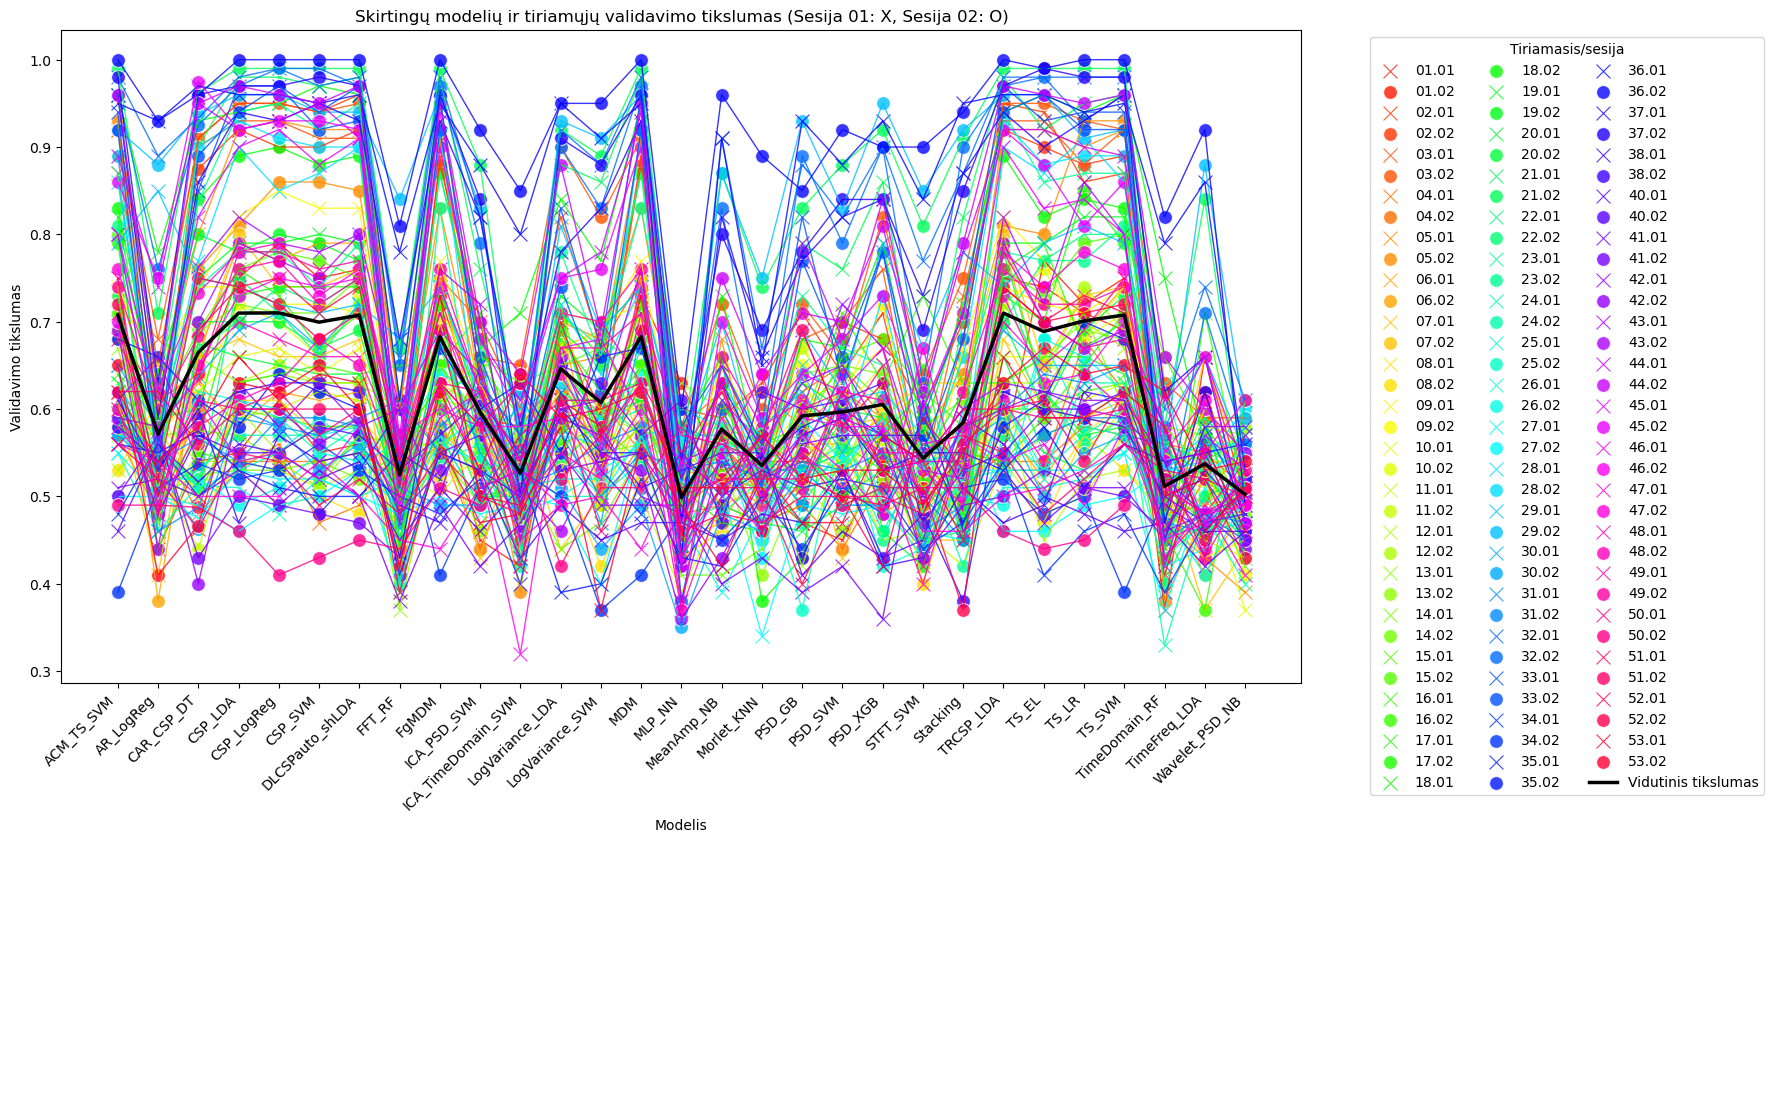

In [123]:
# Prepare data for plotting
df_val_acc = df.xs('val_accuracy', level=2, axis=1)
df_val_acc.columns = pd.MultiIndex.from_tuples(df_val_acc.columns, names=["Subject_Run", "Model"])
df_plot = df_val_acc.stack(level=["Subject_Run", "Model"]).reset_index()
df_plot.columns = ['Index', 'Subject_Run', 'Model', 'Validation Accuracy']

# Assign colors to subjects and shapes to runs
subject_ids = sorted(set(df_plot['Subject_Run'].str[:2]))  # Extract unique subject IDs
subject_color_map = {subject: color for subject, color in zip(subject_ids, sns.color_palette("hsv", len(subject_ids)))}

run_shape_map = {'01': 'x', '02': 'o'}  # Shapes for runs

# Add color and shape columns
df_plot['Color'] = df_plot['Subject_Run'].str[:2].map(subject_color_map)
df_plot['Run'] = df_plot['Subject_Run'].str[-2:]

# Resolve duplicates by averaging Validation Accuracy
df_plot = df_plot.groupby(['Model', 'Subject_Run', 'Run'], as_index=False)['Validation Accuracy'].mean()

fig, axs = plt.subplots(2, 1, figsize=(16, 14), gridspec_kw={'height_ratios': [2, 1]})
ax = axs[0]
# plt.figure(figsize=(16, 8))
for subject in subject_ids:
    subject_data = df_plot[df_plot['Subject_Run'].str[:2] == subject]
    for run, shape in run_shape_map.items():
        subset = subject_data[subject_data['Run'] == run]
        sns.scatterplot(
            data=subset,
            x='Model',
            y='Validation Accuracy',
            color=subject_color_map[subject],
            marker=shape,
            s=100,
            alpha=0.8,
            label=f"{subject}.{run}",
            ax=ax
        )

    # Add lines connecting runs for the same subject across models
    subject_runs = subject_data.pivot(index='Model', columns='Run', values='Validation Accuracy')
    if '01' in subject_runs.columns and '02' in subject_runs.columns:
        ax.plot(
            subject_runs.index,
            subject_runs[['01', '02']],
            color=subject_color_map[subject],
            alpha=0.8,
            linewidth=1
        )
# Add a black line for the mean accuracy per model
model_means = df_plot.groupby('Model')['Validation Accuracy'].mean()
ax.plot(
    model_means.index,
    model_means.values,
    color='black',
    linewidth=2.5,
    label='Vidutinis tikslumas'
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# ax.set_ylabel('Validation Accuracy')
# ax.set_title('Validation Accuracy Across Models and Subjects (Run 01: X, Run 02: O) with Connecting Lines')
# ax.legend(title='Subject/Run', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

ax.set_ylabel('Validavimo tikslumas')
ax.set_xlabel('Modelis')
ax.set_title('Skirtingų modelių ir tiriamųjų validavimo tikslumas (Sesija 01: X, Sesija 02: O)')
ax.legend(title='Tiriamasis/sesija', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

# Lower plot (empty or for additional customization)
ax = axs[1]

# Add text at a specific position
ax.text(0.5, 0.5, 
        '',
        
        fontsize=16, ha='center', va='center', color='black')

# Remove axes
ax.axis('off')

# Display the plot
plt.show()

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\2247193515.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_plot = df_val_acc.stack(level=["Subject_Run", "Model"]).reset_index()
C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\2247193515.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_pipelines = df_plot.groupby('Model')['Validation Accuracy'].mean().nlargest(10).index
C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\2247193515.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False 

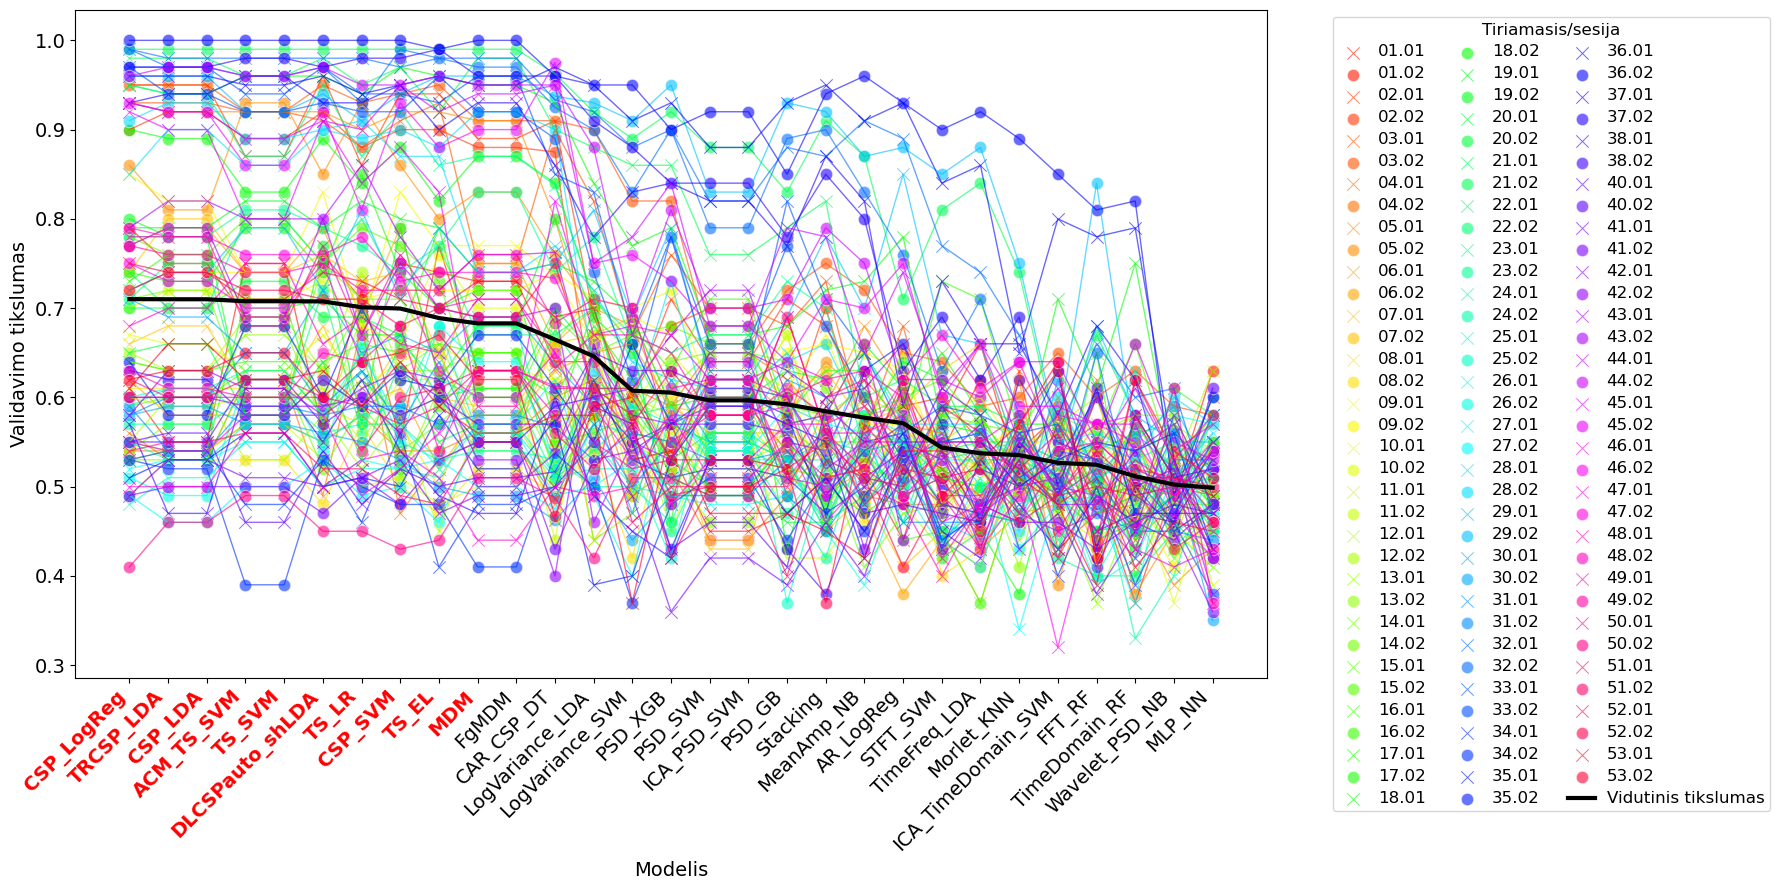

In [211]:
# Prepare data for plotting
df_val_acc = df.xs('val_accuracy', level=2, axis=1)
df_val_acc.columns = pd.MultiIndex.from_tuples(df_val_acc.columns, names=["Subject_Run", "Model"])
df_plot = df_val_acc.stack(level=["Subject_Run", "Model"]).reset_index()
df_plot.columns = ['Index', 'Subject_Run', 'Model', 'Validation Accuracy']

# Assign colors to subjects and shapes to runs
subject_ids = sorted(set(df_plot['Subject_Run'].str[:2]))  # Extract unique subject IDs
subject_color_map = {subject: color for subject, color in zip(subject_ids, sns.color_palette("hsv", len(subject_ids)))}

run_shape_map = {'01': 'x', '02': 'o'}  # Shapes for runs

# Add color and shape columns
df_plot['Color'] = df_plot['Subject_Run'].str[:2].map(subject_color_map)
df_plot['Run'] = df_plot['Subject_Run'].str[-2:]

# Resolve duplicates by averaging Validation Accuracy
df_plot = df_plot.groupby(['Model', 'Subject_Run', 'Run'], as_index=False)['Validation Accuracy'].mean()

# Sort models by mean accuracy in descending order
df_plot['Model'] = pd.Categorical(df_plot['Model'], categories=df_plot.groupby('Model')['Validation Accuracy'].mean().sort_values(ascending=False).index, ordered=True)

# Identify top 10 pipelines by mean accuracy
top_pipelines = df_plot.groupby('Model')['Validation Accuracy'].mean().nlargest(10).index

fig, ax = plt.subplots(figsize=(18, 9))
# plt.figure(figsize=(16, 8))
for subject in subject_ids:
    subject_data = df_plot[df_plot['Subject_Run'].str[:2] == subject]
    for run, shape in run_shape_map.items():
        subset = subject_data[subject_data['Run'] == run]
        sns.scatterplot(
            data=subset,
            x='Model',
            y='Validation Accuracy',
            color=subject_color_map[subject],
            marker=shape,
            s=80,  # Reduced size for markers
            alpha=0.6,  # Reduced transparency for less flashy effect
            label=f"{subject}.{run}",
            ax=ax
        )

    # Add lines connecting runs for the same subject across models
    subject_runs = subject_data.pivot(index='Model', columns='Run', values='Validation Accuracy')
    if '01' in subject_runs.columns and '02' in subject_runs.columns:
        ax.plot(
            subject_runs.index,
            subject_runs[['01', '02']],
            color=subject_color_map[subject],
            alpha=0.6,  # Lower transparency for less flashy effect
            linewidth=1
        )

# Bold the top 10 pipelines on the x-axis
def make_bold_xticks(ax, top_pipelines):
    xticks = ax.get_xticks()
    xticklabels = ax.get_xticklabels()
    for i, label in enumerate(xticklabels):
        if label.get_text() in top_pipelines:
            label.set_fontweight('bold')
            label.set_color('red')
    ax.set_xticklabels(xticklabels, rotation=45, ha='right')

# Add a black line for the mean accuracy per model
model_means = df_plot.groupby('Model')['Validation Accuracy'].mean()
ax.plot(
    model_means.index,
    model_means.values,
    color='black',
    linewidth=3,  # Thicker black line
    alpha=1,  # Lower opacity
    label='Vidutinis tikslumas'
)

make_bold_xticks(ax, top_pipelines)

ax.set_ylabel('Validavimo tikslumas')
ax.set_xlabel('Modelis')
# ax.set_title('Skirtingų modelių ir tiriamųjų validavimo tikslumas (Sesija 01: X, Sesija 02: O)')
ax.legend(title='Tiriamasis/sesija', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)

set_plot_styles(ax, title_size=18, label_size=14, tick_size=14, legend_size=12)

# Display the plot
plt.tight_layout()
plt.show()


In [1]:
python

NameError: name 'python' is not defined

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3221811480.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby('Model')['Validation Accuracy']


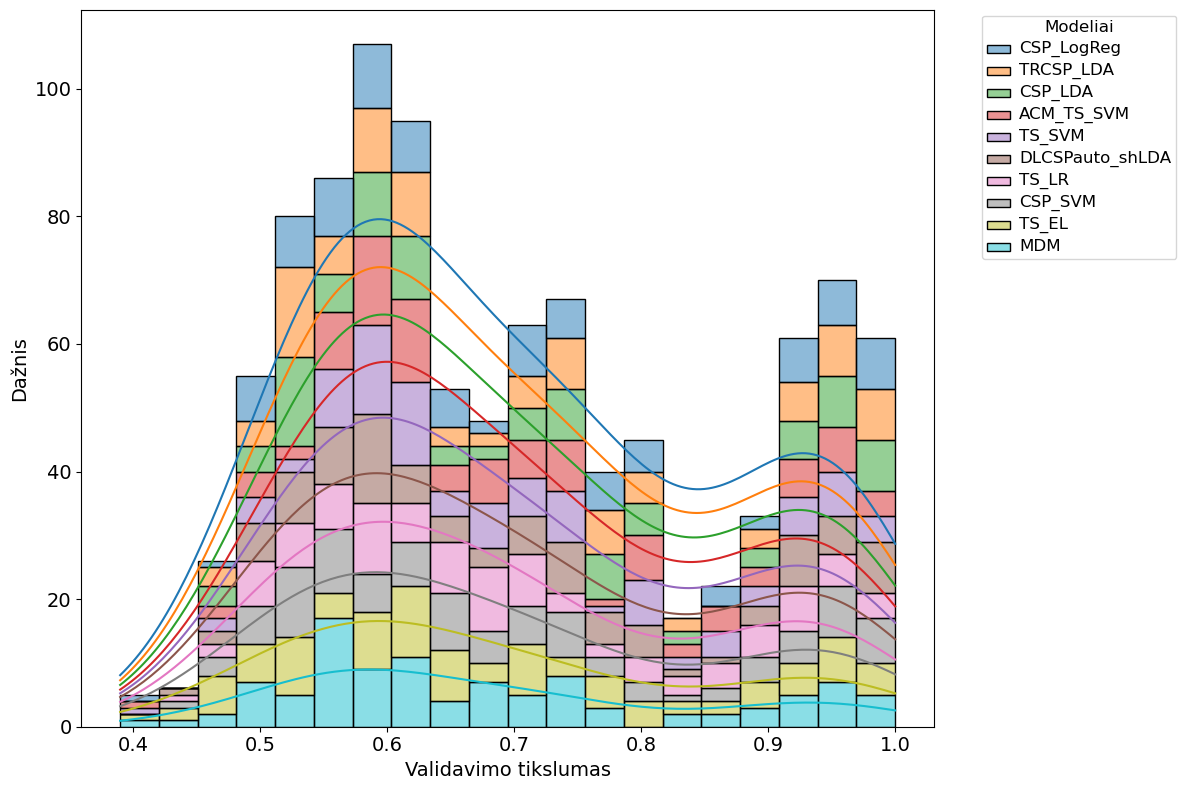

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the top 10 pipelines by mean validation accuracy
top_pipelines = (
    df_plot.groupby('Model')['Validation Accuracy']
    .mean()
    .nlargest(10)
    .index
)

# Filter data to include only the top 10 pipelines
filtered_df_plot = df_plot[df_plot['Model'].isin(top_pipelines)]

# Plot the histogram
plt.figure(figsize=(12, 8))
histplot = sns.histplot(
    data=filtered_df_plot,
    x='Validation Accuracy',
    hue='Model',
    bins=20,
    kde=True,
    palette='tab10',
    multiple='stack'
)

# Retrieve and filter legend handles and labels for only the top pipelines
handles, labels = histplot.get_legend().legend_handles, histplot.get_legend().texts
filtered_labels = [label.get_text() for label in labels if label.get_text() in top_pipelines]

# Update the legend to show only the top pipelines
plt.legend(
    handles=handles[:len(filtered_labels)],
    labels=filtered_labels,
    title='Modeliai',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize='small'
)

# Customize the plot
plt.xlabel('Validavimo tikslumas')
plt.ylabel('Dažnis')

set_plot_styles(histplot.axes, title_size=18, label_size=14, tick_size=14, legend_size=12)

plt.tight_layout()
plt.show()


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\2518701239.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


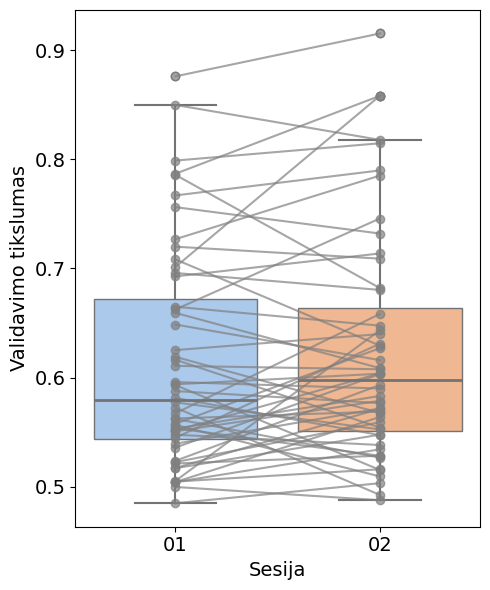

In [301]:
# Calculate the mean accuracy across runs for sorting
df_pivot['Mean Accuracy'] = df_pivot[['01', '02']].mean(axis=1)

# Sort subjects by mean accuracy (or you can sort by other criteria, like differences between runs)
df_pivot = df_pivot.sort_values(by='Mean Accuracy', ascending=False)

# Melt the sorted data for plotting
df_melt_sorted = pd.melt(
    df_pivot.drop(columns='Mean Accuracy'),  # Drop Mean Accuracy column after sorting
    id_vars='Subject',
    value_vars=['01', '02'],
    var_name='Run',
    value_name='Validation Accuracy'
)

# Create the plot
fig, ax = plt.subplots(figsize=(5, 6))

# Boxplot for Run 1 and Run 2
sns.boxplot(
    data=df_melt_sorted,
    x='Run',
    y='Validation Accuracy',
    palette='pastel',
    ax=ax,
    whiskerprops=dict(linewidth=1.5),  # Thicker whiskers
    capprops=dict(linewidth=1.5),
    medianprops=dict(linewidth=2)  
  
)

# Add connecting lines for sorted subjects
for _, row in df_pivot.iterrows():
    ax.plot(
        ['01', '02'],  # x-coordinates for runs
        [row['01'], row['02']],  # y-coordinates for validation accuracies
        marker='o',
        color='gray',
        alpha=0.7
    )
set_plot_styles(ax, title_size=18, label_size=14, tick_size=14, legend_size=12)

# Set labels and title
ax.set_ylabel('Validavimo tikslumas')
ax.set_xlabel('Sesija')
# ax.set_title('Sorted Validation Accuracy by Subject: Run 1 vs Run 2')

# Show plot
plt.tight_layout()
plt.show()


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\424840445.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


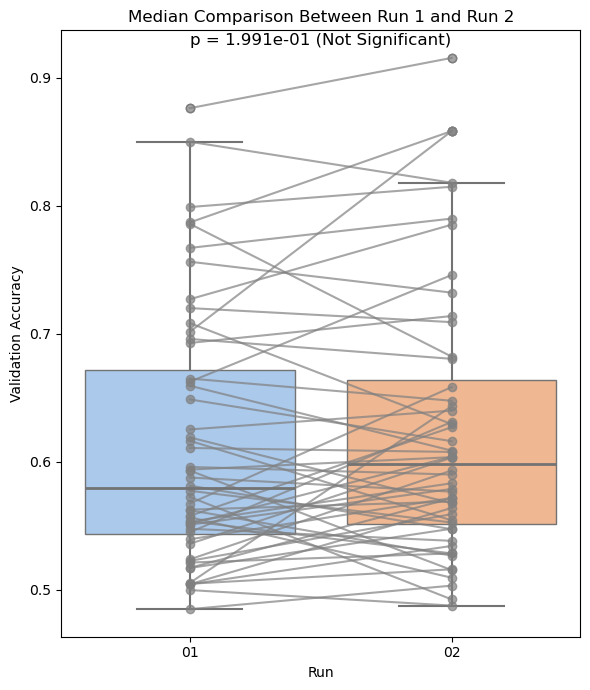

In [299]:
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns

# Perform Wilcoxon signed-rank test to check significance of median difference
run1_values = df_pivot['01']
run2_values = df_pivot['02']

stat, p_value = wilcoxon(run1_values, run2_values)
significance_text = f'p = {p_value:.3e} {"(Significant)" if p_value < 0.05 else "(Not Significant)"}'

# Create the plot
fig, ax = plt.subplots(figsize=(6, 7))

# Boxplot for Run 1 and Run 2
sns.boxplot(
    data=df_melt_sorted,
    x='Run',
    y='Validation Accuracy',
    palette='pastel',
    ax=ax,
    whiskerprops=dict(linewidth=1.5),  # Thicker whiskers
    capprops=dict(linewidth=1.5),
    medianprops=dict(linewidth=2)  # Thicker median line
)

# Add connecting lines for sorted subjects
for _, row in df_pivot.iterrows():
    ax.plot(
        ['01', '02'],  # x-coordinates for runs
        [row['01'], row['02']],  # y-coordinates for validation accuracies
        marker='o',
        color='gray',
        alpha=0.7
    )

# Annotate significance on the plot
ax.text(0.5, max(run1_values.max(), run2_values.max()) + 0.01,  # Position above the plot
        significance_text,
        fontsize=12,
        color='black',
        ha='center')

# Set labels and title
ax.set_ylabel('Validation Accuracy')
ax.set_xlabel('Run')
ax.set_title('Median Comparison Between Run 1 and Run 2')

# Show plot
plt.tight_layout()
plt.show()


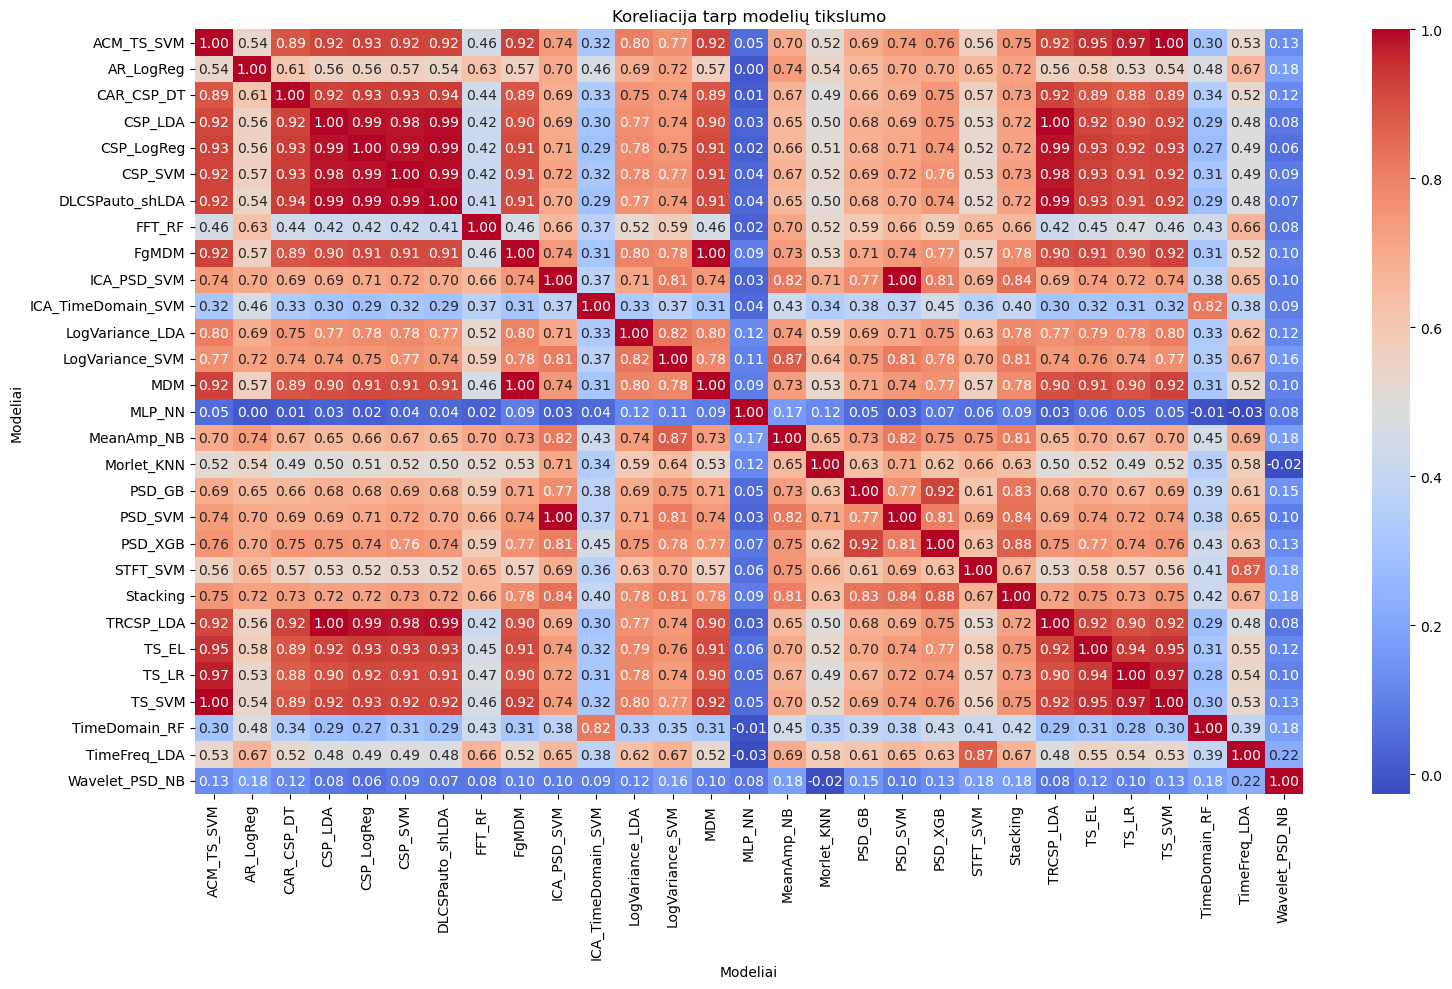

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data for correlation analysis
pivoted_data = df_plot.pivot(index='Subject_Run', columns='Model', values='Validation Accuracy')

# Compute correlation matrix
correlation_matrix = pivoted_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True
)
plt.title('Koreliacija tarp modelių tikslumo')
plt.xlabel('Modeliai')
plt.ylabel('Modeliai')

# Display the plot
plt.tight_layout()
plt.show()


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\392702211.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby('Model')['Validation Accuracy']


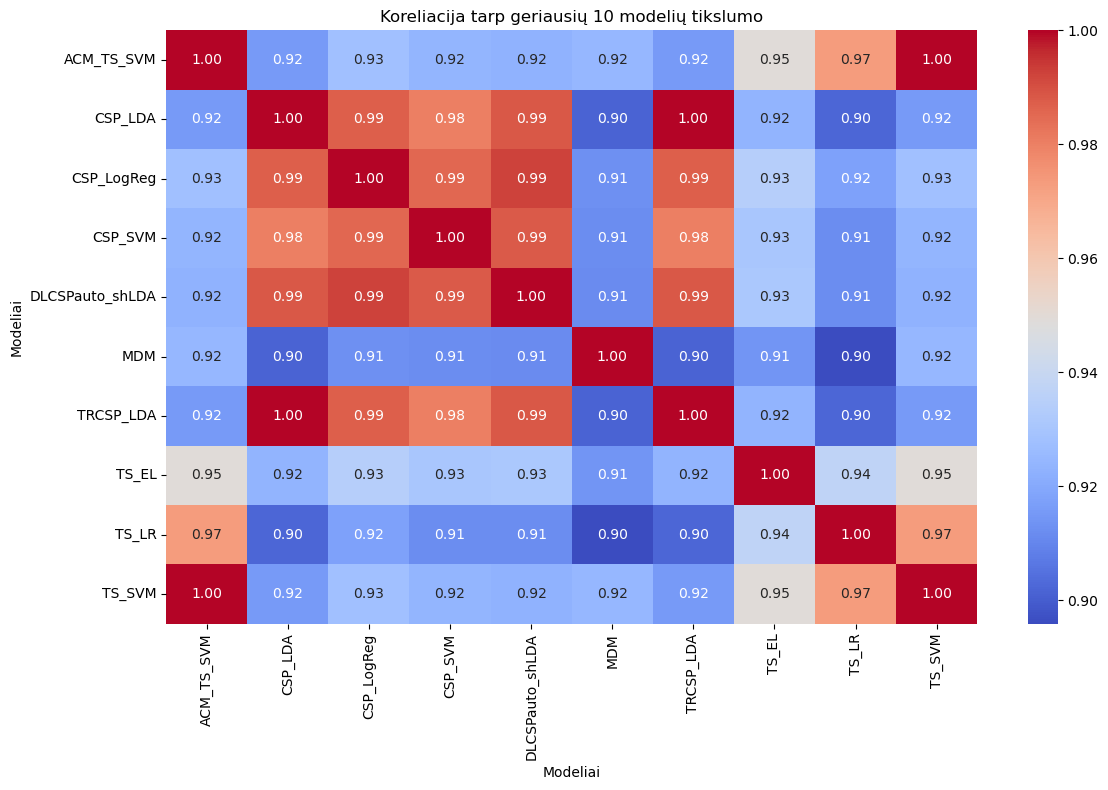

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the top 10 pipelines by mean validation accuracy
top_pipelines = (
    df_plot.groupby('Model')['Validation Accuracy']
    .mean()
    .nlargest(10)
    .index
)

# Filter data to include only the top 10 pipelines
filtered_df_plot = df_plot[df_plot['Model'].isin(top_pipelines)]

# Prepare data for correlation analysis
pivoted_data = filtered_df_plot.pivot(index='Subject_Run', columns='Model', values='Validation Accuracy')

# Compute correlation matrix
correlation_matrix = pivoted_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True
)
plt.title('Koreliacija tarp geriausių 10 modelių tikslumo')
plt.xlabel('Modeliai')
plt.ylabel('Modeliai')
set_plot_styles(histplot.axes, title_size=18, label_size=14, tick_size=14, legend_size=12)

# Display the plot
plt.tight_layout()
plt.show()


In [126]:
pivoted_data

Model        ACM_TS_SVM  CSP_LDA  CSP_LogReg  CSP_SVM  DLCSPauto_shLDA  FgMDM  \
Subject_Run                                                                     
01-01              0.75     0.55        0.61     0.55             0.56   0.63   
01-02              0.69     0.75        0.79     0.75             0.76   0.73   
02-01              0.87     0.95        0.95     0.94             0.96   0.89   
02-02              0.89     0.92        0.90     0.90             0.92   0.88   
03-01              0.92     0.93        0.93     0.91             0.91   0.75   
...                 ...      ...         ...      ...              ...    ...   
51-02              0.62     0.60        0.60     0.60             0.60   0.63   
52-01              0.71     0.74        0.75     0.71             0.74   0.73   
52-02              0.72     0.74        0.72     0.68             0.71   0.69   
53-01              0.62     0.66        0.61     0.64             0.63   0.56   
53-02              0.65     0.63        0.62     0.65             0.60   0.62   

Model        TRCSP_LDA  TS_EL  TS_LR  TS_SVM  
Subject_Run                                   
01-01             0.55   0.77   0.72    0.75  
01-02             0.75   0.74   0.71    0.69  
02-01             0.95   0.94   0.86    0.87  
02-02             0.92   0.90   0.88    0.89  
03-01             0.93   0.93   0.88    0.92  
...                ...    ...    ...     ...  
51-02             0.60   0.61   0.54    0.62  
52-01             0.74   0.70   0.73    0.71  
52-02             0.74   0.70   0.71    0.72  
53-01             0.66   0.59   0.59    0.62  
53-02             0.63   0.67   0.64    0.65  

[104 rows x 10 columns]

# grafikai kur subject-run ir acc, geriau atrodytu jei sortas butu pagal acc tada matytusi ir vidurkis ir kiekis zmoniu ties skirtingais treshold

### Paplotinau apačioj subjet-run ant x ašies

In [ ]:
model_means = df_plot.groupby('Model')['Validation Accuracy'].mean()

In [73]:
df_sorted = df_plot.sort_values(by='Validation Accuracy', ascending=False)
df_sorted

Model Subject_Run Run  Validation Accuracy
71            ACM_TS_SVM       36-02  02                 1.00
2671              TS_SVM       36-02  02                 1.00
383              CSP_LDA       36-02  02                 1.00
591              CSP_SVM       36-02  02                 1.00
2359           TRCSP_LDA       36-02  02                 1.00
...                  ...         ...  ..                  ...
1537              MLP_NN       42-02  02                 0.36
1515              MLP_NN       30-02  02                 0.35
1716          Morlet_KNN       27-01  01                 0.34
2750       TimeDomain_RF       24-01  01                 0.33
1128  ICA_TimeDomain_SVM       46-01  01                 0.32

[3016 rows x 4 columns]

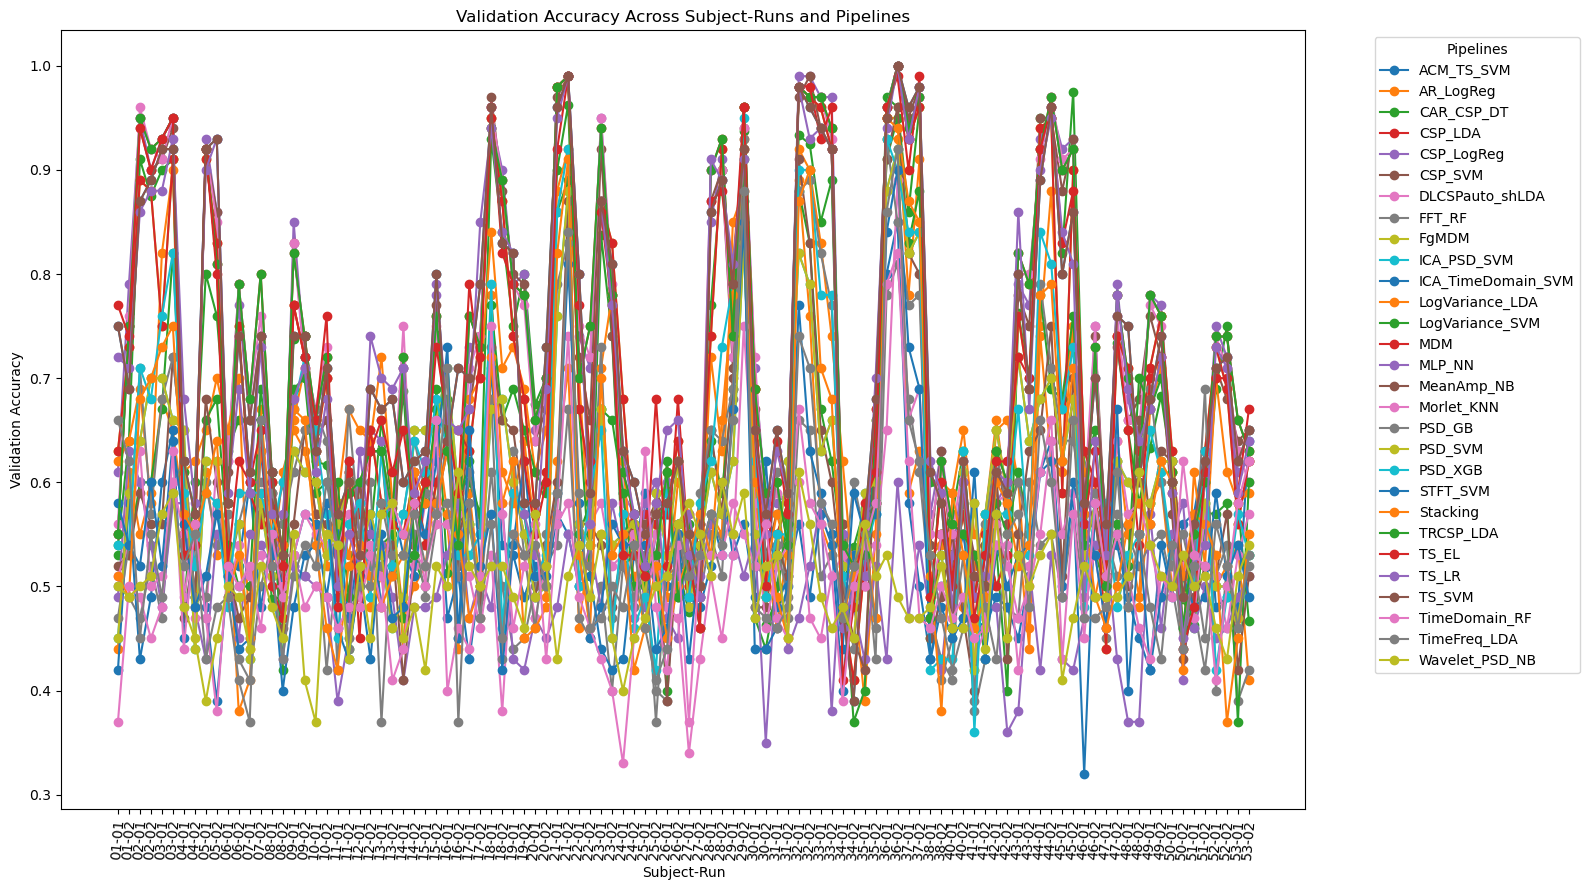

In [78]:
import matplotlib.pyplot as plt

pipelines = df_plot['Model'].unique()

plt.figure(figsize=(16, 9))
for pipeline in pipelines:
    subset = df_plot[df_plot['Model'] == pipeline]
    # Sort by Subject_Run for consistent line connection
    subset = subset.sort_values(by='Subject_Run')
    
    plt.plot(
        subset['Subject_Run'], 
        subset['Validation Accuracy'], 
        marker='o', 
        label=pipeline
    )

# Customize the plot
plt.title("Validation Accuracy Across Subject-Runs and Pipelines")
plt.xlabel("Subject-Run")
plt.ylabel("Validation Accuracy")
plt.xticks(rotation=85)  # Rotate x-axis labels for better readability
plt.legend(title="Pipelines", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [90]:
model_means.sort_values(ascending=False).head(15) #best models by validation

Model
CSP_LogReg         0.710096
TRCSP_LDA          0.709904
CSP_LDA            0.709904
ACM_TS_SVM         0.707692
TS_SVM             0.707692
DLCSPauto_shLDA    0.707500
TS_LR              0.700962
CSP_SVM            0.699519
TS_EL              0.688846
MDM                0.682885
FgMDM              0.682885
CAR_CSP_DT         0.664832
LogVariance_LDA    0.646058
LogVariance_SVM    0.607500
PSD_XGB            0.605288
Name: Validation Accuracy, dtype: float64

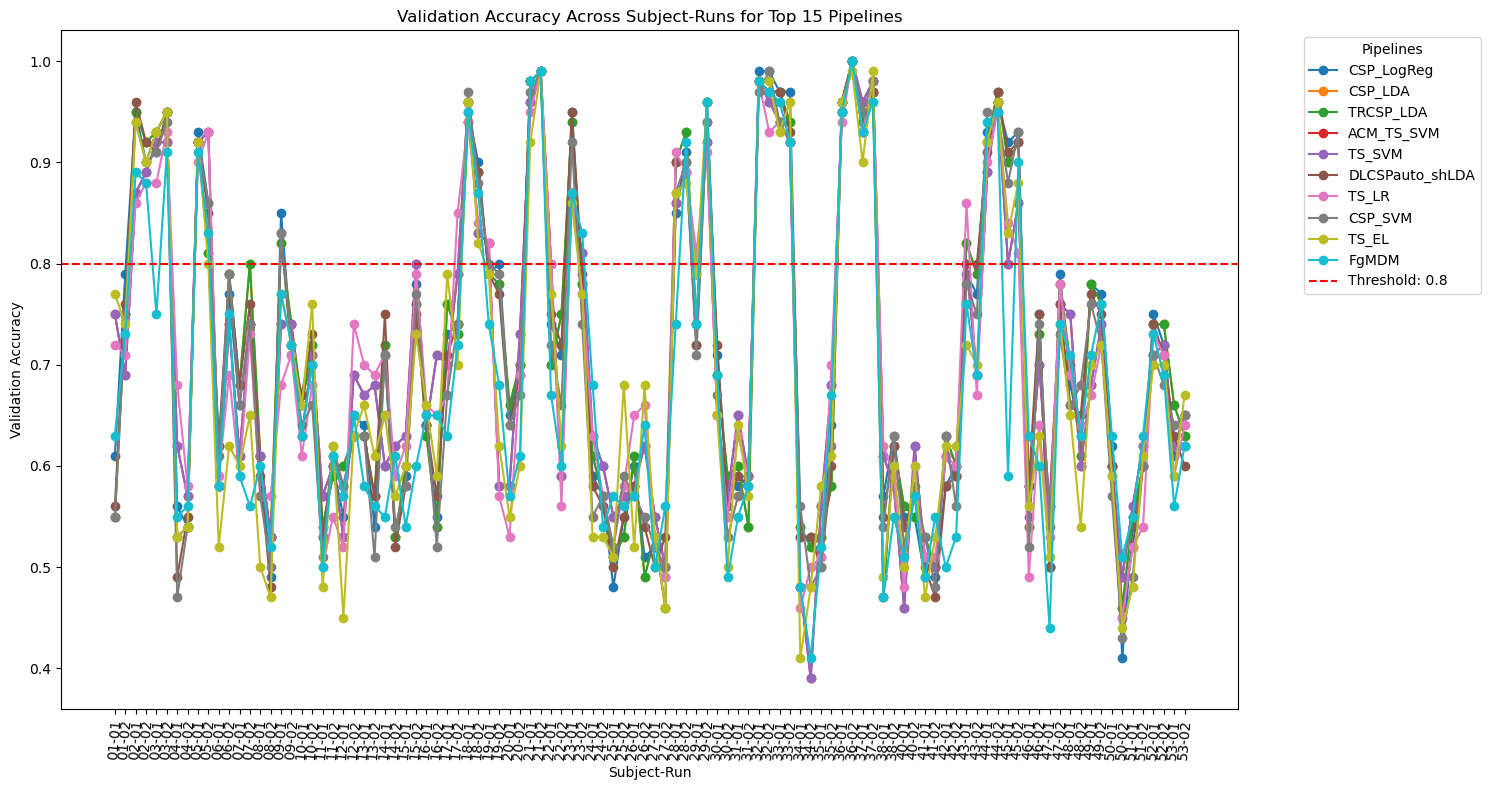

In [92]:
import matplotlib.pyplot as plt

# Calculate the mean Validation Accuracy for each pipeline
top_pipelines = (
    df_plot.groupby('Model')['Validation Accuracy']
    .mean()
    .nlargest(10)  # Select the top 15 pipelines by mean accuracy
    .index
)

top_df_plot = df_plot[df_plot['Model'].isin(top_pipelines)]

plt.figure(figsize=(15, 8))
for pipeline in top_pipelines:
    subset = top_df_plot[top_df_plot['Model'] == pipeline]
    # Sort by Subject_Run for consistent line connection
    subset = subset.sort_values(by='Subject_Run')
    plt.plot(
        subset['Subject_Run'], 
        subset['Validation Accuracy'], 
        marker='o', 
        label=pipeline
    )

plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='Threshold: 0.8')

# Customize the plot
plt.title("Validation Accuracy Across Subject-Runs for Top 15 Pipelines")
plt.xlabel("Subject-Run")
plt.ylabel("Validation Accuracy")
plt.xticks(rotation=85)  # Rotate x-axis labels for better readability
plt.legend(title="Pipelines", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


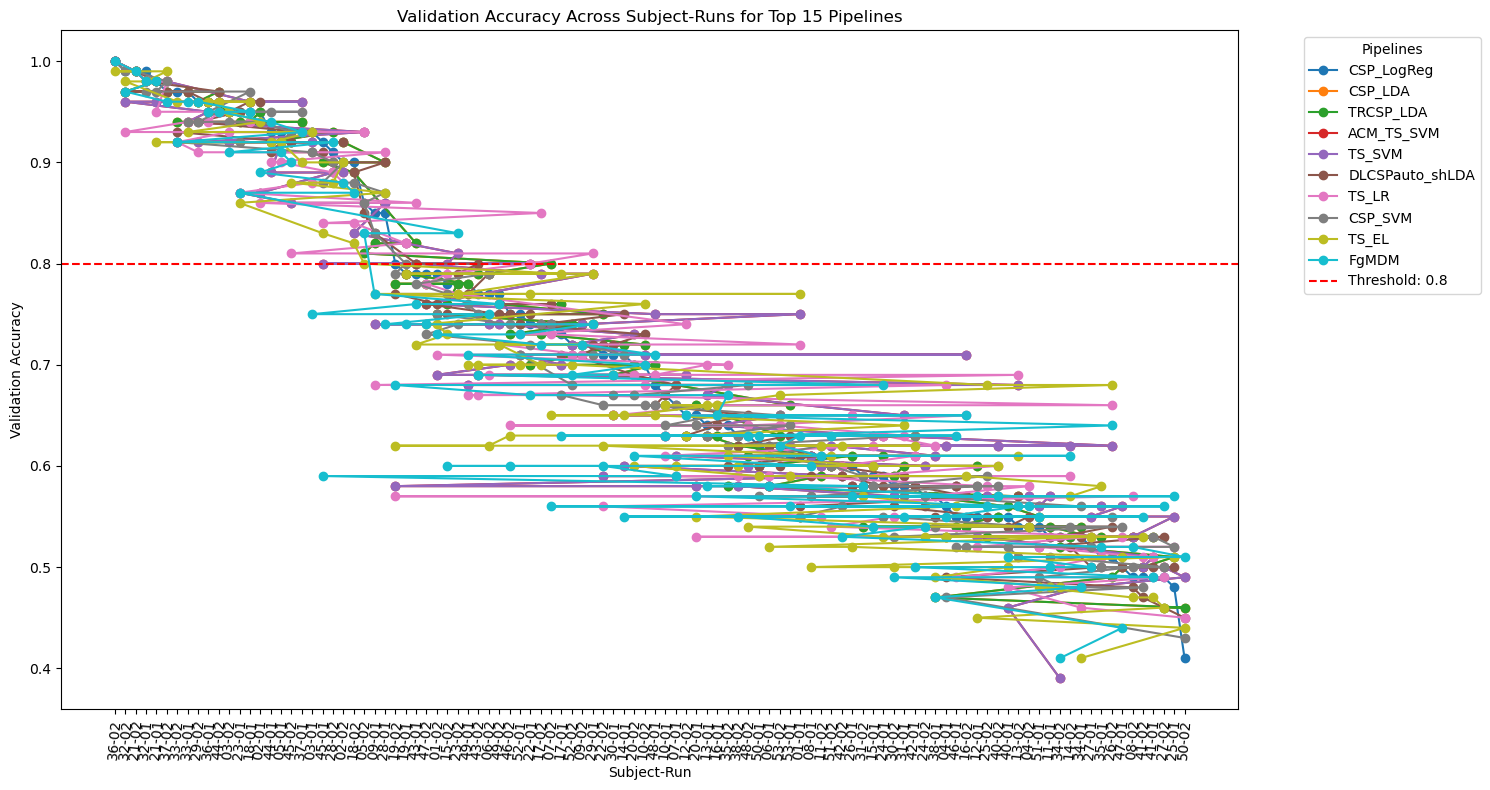

In [93]:
import matplotlib.pyplot as plt

# Calculate the mean Validation Accuracy for each pipeline
top_pipelines = (
    df_plot.groupby('Model')['Validation Accuracy']
    .mean()
    .nlargest(10)  # Select the top 15 pipelines by mean accuracy
    .index
)

top_df_plot = df_plot[df_plot['Model'].isin(top_pipelines)]

plt.figure(figsize=(15, 8))
for pipeline in top_pipelines:
    subset = top_df_plot[top_df_plot['Model'] == pipeline]
    # Sort by Subject_Run for consistent line connection
    subset = subset.sort_values(by='Validation Accuracy', ascending=False)
    plt.plot(
        subset['Subject_Run'], 
        subset['Validation Accuracy'], 
        marker='o', 
        label=pipeline
    )

plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='Threshold: 0.8')

# Customize the plot
plt.title("Validation Accuracy Across Subject-Runs for Top 15 Pipelines")
plt.xlabel("Subject-Run")
plt.ylabel("Validation Accuracy")
plt.xticks(rotation=85)  # Rotate x-axis labels for better readability
plt.legend(title="Pipelines", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3722583409.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


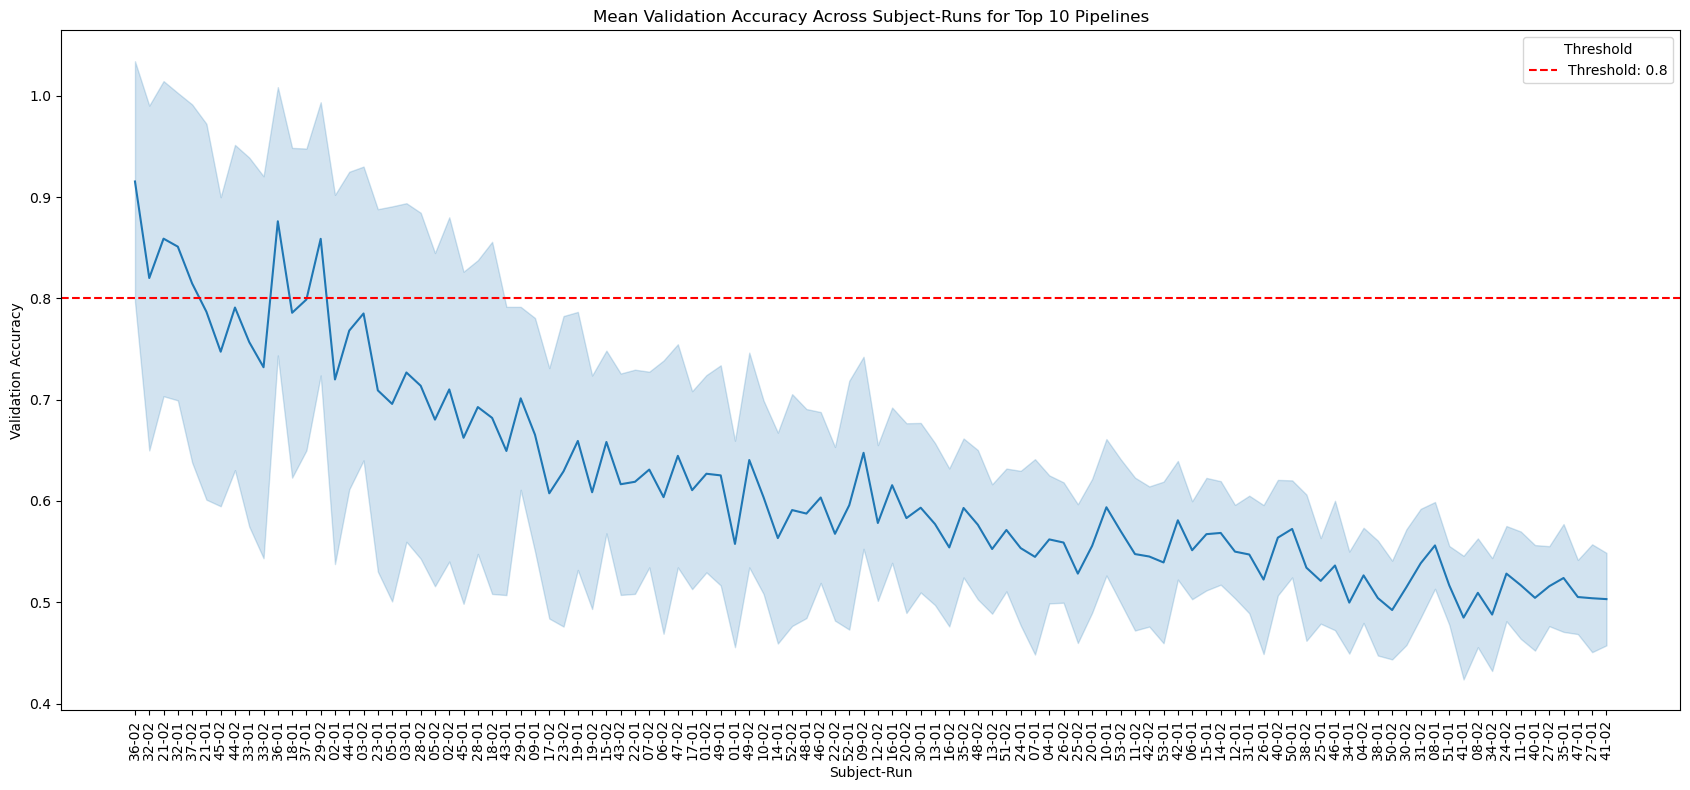

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean Validation Accuracy for each pipeline
top_pipelines = (
    df_plot.groupby('Model')['Validation Accuracy']
    .mean()
    .nlargest(29)  # Select the top 10 pipelines by mean accuracy
    .index
)

# Filter the DataFrame to only include the top pipelines
top_df_plot = df_plot[df_plot['Model'].isin(top_pipelines)]

# Sort by Validation Accuracy in descending order for each pipeline
top_df_plot = top_df_plot.sort_values(by='Validation Accuracy', ascending=False)

# Plot the mean with variation shadow using seaborn
plt.figure(figsize=(17, 8))
sns.lineplot(
    data=top_df_plot,
    x='Subject_Run',
    y='Validation Accuracy',
    ci='sd',  # Adds a shadow for standard deviation
    estimator='mean',  # Plots the mean Validation Accuracy across pipelines
)

# Add a threshold line
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='Threshold: 0.8')

# Customize the plot
plt.title("Mean Validation Accuracy Across Subject-Runs for Top 10 Pipelines")
plt.xlabel("Subject-Run")
plt.ylabel("Validation Accuracy")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(title="Threshold", loc='upper right')
plt.tight_layout()
plt.show()


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3333835284.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_plot.groupby('Model')['Validation Accuracy']
C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3333835284.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  lineplot = sns.lineplot(


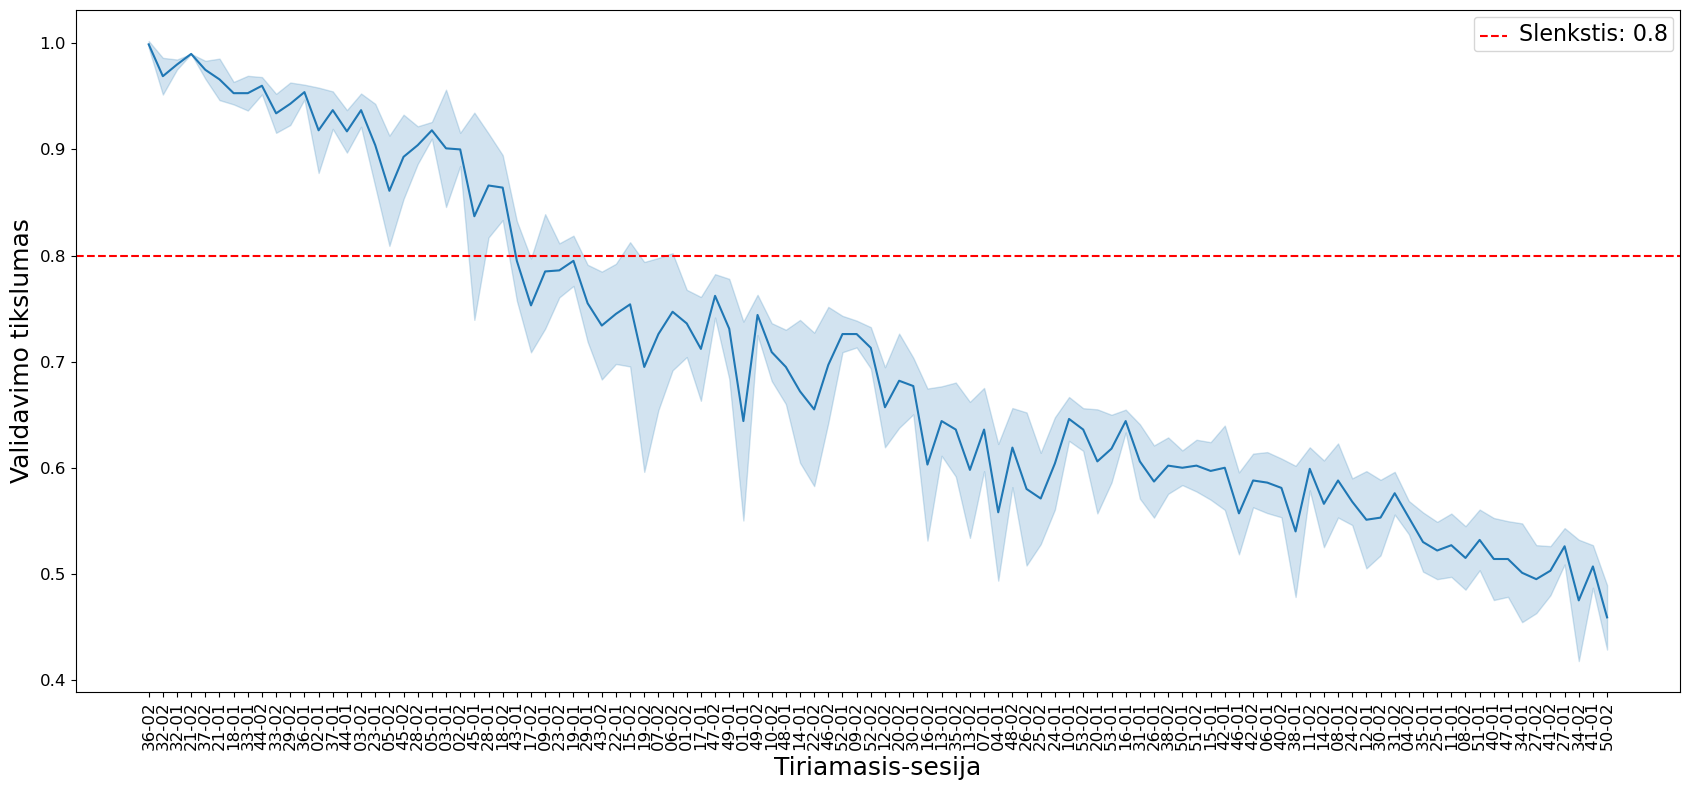

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the mean Validation Accuracy for each pipeline
top_pipelines = (
    df_plot.groupby('Model')['Validation Accuracy']
    .mean()
    .nlargest(10)  # Select the top 10 pipelines by mean accuracy
    .index
)

# Filter the DataFrame to only include the top pipelines
top_df_plot = df_plot[df_plot['Model'].isin(top_pipelines)]

# Sort by Validation Accuracy in descending order for each pipeline
top_df_plot = top_df_plot.sort_values(by='Validation Accuracy', ascending=False)

# Plot the mean with variation shadow using seaborn
plt.figure(figsize=(17, 8))
lineplot = sns.lineplot(
    data=top_df_plot,
    x='Subject_Run',
    y='Validation Accuracy',
    ci='sd',  # Adds a shadow for standard deviation
    estimator='mean',  # Plots the mean Validation Accuracy across pipelines
)

# Add a threshold line
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='Slenkstis: 0.8')

# Customize the plot
# plt.title("Vidutinis validavimo tikslumas tarp tiriamųjų-sesijų naudojant 10 geriausių modelių")
plt.xlabel("Tiriamasis-sesija")
plt.ylabel("Validavimo tikslumas")

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.legend(loc='upper right')  # Place legend in the upper right corner

# Apply plot styles
set_plot_styles(plt.gca(), title_size=18, label_size=18, tick_size=12, legend_size=16)

plt.tight_layout()
plt.show()


In [303]:
#34 su .drop_duplicates('Subject_Run')
#26 su [top_df_plot['Model'] == 'CSP_LogReg']

top_subjects = top_df_plot[top_df_plot['Validation Accuracy'] >= 0.8].drop_duplicates('Subject_Run')
df_plot = top_df_plot[top_df_plot['Subject_Run'].isin(top_subjects['Subject_Run'])][top_df_plot['Model'].isin(top_pipelines)]
len(df_plot.drop_duplicates('Subject_Run'))


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3264345201.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = top_df_plot[top_df_plot['Subject_Run'].isin(top_subjects['Subject_Run'])][top_df_plot['Model'].isin(top_pipelines)]


37

In [304]:
df_plot

Model Subject_Run Run  Validation Accuracy
695   DLCSPauto_shLDA       36-02  02                 1.00
591           CSP_SVM       36-02  02                 1.00
487        CSP_LogReg       36-02  02                 1.00
2567            TS_LR       36-02  02                 1.00
1423              MDM       36-02  02                 1.00
...               ...         ...  ..                  ...
1438              MDM       45-01  01                 0.59
2637           TS_SVM       19-02  02                 0.58
37         ACM_TS_SVM       19-02  02                 0.58
2533            TS_LR       19-02  02                 0.57
1365              MDM       07-02  02                 0.56

[370 rows x 4 columns]

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\2862171687.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


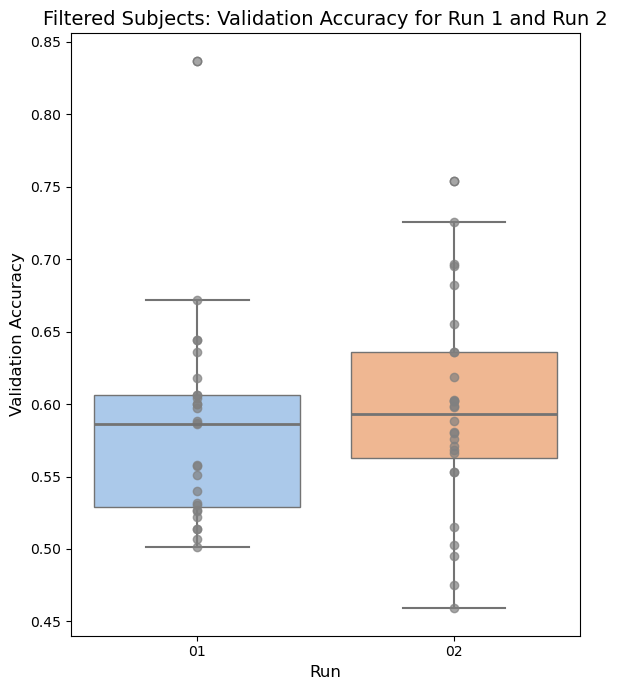

In [315]:
# Assuming `top_df_plot` and `top_pipelines` are defined, let's filter the subjects

# Filter subjects with Validation Accuracy >= 0.8
top_subjects = top_df_plot[
    (top_df_plot['Validation Accuracy'] >= 0.5) & 
    (top_df_plot['Validation Accuracy'] <= 0.6)
].drop_duplicates('Subject_Run')

# Filter the main dataframe for selected subjects and top models
filtered_df_plot = top_df_plot[
    top_df_plot['Subject_Run'].isin(top_subjects['Subject_Run']) &
    top_df_plot['Model'].isin(top_pipelines)
]

# Recalculate pivot table for filtered data
# Pivot table for filtered data
df_pivot_filtered = (
    filtered_df_plot.groupby(['Subject_Run', 'Run'], as_index=False)['Validation Accuracy']
    .mean()
    .pivot(index='Subject_Run', columns='Run', values='Validation Accuracy')
)

# Melt the filtered pivot table for boxplot plotting
df_melt_filtered = pd.melt(
    df_pivot_filtered.reset_index(),
    id_vars='Subject_Run',
    value_vars=['01', '02'],
    var_name='Run',
    value_name='Validation Accuracy'
)

# Create the plot for filtered subjects
fig, ax = plt.subplots(figsize=(6, 7))

# Boxplot for Run 1 and Run 2
sns.boxplot(
    data=df_melt_filtered,
    x='Run',
    y='Validation Accuracy',
    palette='pastel',
    ax=ax,
    whiskerprops=dict(linewidth=1.5),  # Thicker whiskers
    capprops=dict(linewidth=1.5),
    medianprops=dict(linewidth=2)  # Thicker median line
)

# Add connecting lines for filtered subjects
for _, row in df_pivot_filtered.iterrows():
    ax.plot(
        ['01', '02'],  # x-coordinates for runs
        [row.get('01', None), row.get('02', None)],  # y-coordinates for validation accuracies
        marker='o',
        color='gray',
        alpha=0.7
    )

# Set plot styles and labels
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_xlabel('Run', fontsize=12)
ax.set_title('Filtered Subjects: Validation Accuracy for Run 1 and Run 2', fontsize=14)
plt.tight_layout()
plt.show()

Wilcoxon Test: Statistic=163.0000, p-value=3.7408e-01


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3455341906.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


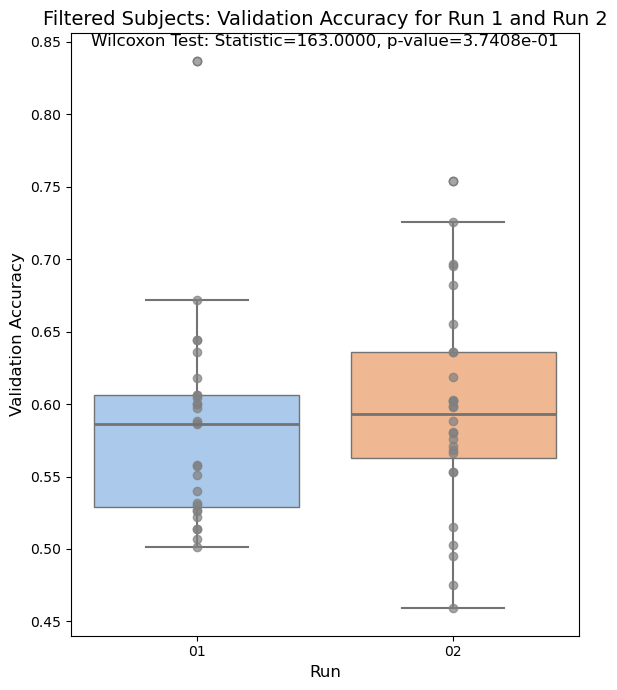

In [316]:
from scipy.stats import wilcoxon

# Extract values for Run 01 and Run 02
run1_values = df_pivot_filtered['01'].dropna()
run2_values = df_pivot_filtered['02'].dropna()

# Perform Wilcoxon signed-rank test to check significance between groups
stat, p_value = wilcoxon(run1_values, run2_values)

# Output the results
significance_result = f"Wilcoxon Test: Statistic={stat:.4f}, p-value={p_value:.4e}"
print(significance_result)

# Annotate significance on the plot
fig, ax = plt.subplots(figsize=(6, 7))

# Boxplot for Run 1 and Run 2
sns.boxplot(
    data=df_melt_filtered,
    x='Run',
    y='Validation Accuracy',
    palette='pastel',
    ax=ax,
    whiskerprops=dict(linewidth=1.5),  # Thicker whiskers
    capprops=dict(linewidth=1.5),
    medianprops=dict(linewidth=2)  # Thicker median line
)

# Add connecting lines for filtered subjects
for _, row in df_pivot_filtered.iterrows():
    ax.plot(
        ['01', '02'],  # x-coordinates for runs
        [row.get('01', None), row.get('02', None)],  # y-coordinates for validation accuracies
        marker='o',
        color='gray',
        alpha=0.7
    )

# Add statistical significance text
ax.text(0.5, max(run1_values.max(), run2_values.max()) + 0.01,  # Position above the plot
        significance_result,
        fontsize=12,
        color='black',
        ha='center')

# Set plot styles and labels
ax.set_ylabel('Validation Accuracy', fontsize=12)
ax.set_xlabel('Run', fontsize=12)
ax.set_title('Filtered Subjects: Validation Accuracy for Run 1 and Run 2', fontsize=14)
plt.tight_layout()
plt.show()


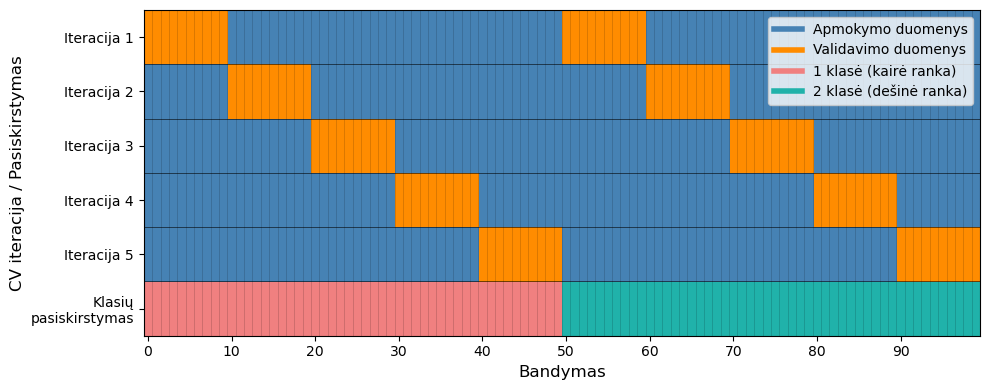

In [275]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Generate sample data
n_samples = 100
X = np.zeros(n_samples)  # Dummy feature array
y = np.array([0] * 50 + [1] * 50)  # Binary classification target

# Define Stratified K-Fold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits)

# Create a matrix to represent the splits
matrix = np.zeros((n_splits, n_samples), dtype=int)

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    matrix[fold_idx, train_idx] = 1  # Training samples marked as 1
    matrix[fold_idx, val_idx] = 2  # Validation samples marked as 2

# Enhanced plot for Stratified K-Fold Splits
# Enhanced plot for Stratified K-Fold Splits with individual sample lines and muted colors
# Enhanced plot for Stratified K-Fold Splits with class distribution and updated legend
# Enhanced plot for Stratified K-Fold Splits with class distribution and Lithuanian language

fig, ax = plt.subplots(figsize=(10, 4))

# Define a colormap and norm for the matrix, including class distribution colors
cmap = mcolors.ListedColormap(["white", "steelblue", "darkorange", "lightcoral", "lightseagreen"])
bounds = [0, 1, 2, 3, 4, 5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Update the distribution row with distinct class colors
distribution_row = np.array([3 if i < n_samples / 2 else 4 for i in range(n_samples)])
matrix_with_distribution = np.vstack([matrix, distribution_row])

# Display the matrix as an image
im = ax.imshow(matrix_with_distribution, aspect="auto", cmap=cmap, norm=norm, interpolation="none")

# Add gridlines to show individual samples clearly
for i in range(n_splits + 2):  # Add one more for the distribution row
    ax.axhline(i - 0.5, color="black", linewidth=0.5, alpha=0.8)  # Horizontal lines
for j in range(n_samples + 1):
    ax.axvline(j - 0.5, color="black", linewidth=0.5, alpha=0.2)  # Vertical lines

# Add labels and ticks
# ax.set_title("Stratifikuoto K-Fold Pasiskirstymas su Klasių Vizualizacija", fontsize=14)
ax.set_xlabel("Bandymas", fontsize=12)
ax.set_ylabel("CV iteracija / Pasiskirstymas", fontsize=12)
ax.set_xticks(np.arange(0, n_samples, step=10))
ax.set_yticks(np.arange(n_splits + 1))
ax.set_yticklabels([f"Iteracija {i+1}" for i in range(n_splits)] + ["Klasių\npasiskirstymas"])

# Add legend with updated labels in Lithuanian
legend_handles = [
    plt.Line2D([0], [0], color="steelblue", lw=4, label="Apmokymo duomenys"),
    plt.Line2D([0], [0], color="darkorange", lw=4, label="Validavimo duomenys"),
    plt.Line2D([0], [0], color="lightcoral", lw=4, label="1 klasė (kairė ranka)"),
    plt.Line2D([0], [0], color="lightseagreen", lw=4, label="2 klasė (dešinė ranka)"),
]
ax.legend(handles=legend_handles, loc="upper right", fontsize=10, frameon=True)

plt.tight_layout()
plt.show()


In [11]:
df

01-01                                                        \
      ACM_TS_SVM                                             AR_LogReg   
  train_accuracy train_roc_auc val_accuracy val_roc_auc train_accuracy   
0            1.0           1.0         0.85        0.89         0.7500   
1            1.0           1.0         0.70        0.83         0.7125   
2            1.0           1.0         0.60        0.76         0.7625   
3            1.0           1.0         0.70        0.85         0.7125   
4            1.0           1.0         0.90        0.95         0.6875   

                                                                       ...  \
                                             CAR_CSP_DT                ...   
  train_roc_auc val_accuracy val_roc_auc train_accuracy train_roc_auc  ...   
0      0.845625         0.40        0.43            1.0           1.0  ...   
1      0.821250         0.45        0.49            1.0           1.0  ...   
2      0.842500         0.40        0.37            1.0           1.0  ...   
3      0.839375         0.35        0.46            1.0           1.0  ...   
4      0.806250         0.60        0.55            1.0           1.0  ...   

         53-02                                                        \
         TS_LR                     TS_SVM                              
  val_accuracy val_roc_auc train_accuracy train_roc_auc val_accuracy   
0         0.60        0.69            1.0           1.0         0.75   
1         0.65        0.60            1.0           1.0         0.50   
2         0.70        0.83            1.0           1.0         0.70   
3         0.60        0.65            1.0           1.0         0.60   
4         0.65        0.77            1.0           1.0         0.70   

                                                                     
              Wavelet_PSD_NB                                         
  val_roc_auc train_accuracy train_roc_auc val_accuracy val_roc_auc  
0        0.78         0.5375      0.500312         0.60       0.520  
1        0.51         0.5625      0.537500         0.55       0.490  
2        0.82         0.5375      0.541250         0.55       0.410  
3        0.71         0.5500      0.491250         0.50       0.460  
4        0.80         0.5625      0.503750         0.50       0.485  

[5 rows x 12064 columns]

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\1618855377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_subjects['Subject_ID'] = top_subjects['Subject_Run'].str[:2]
C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\1618855377.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_subjects['Run'] = top_subjects['Subject_Run'].str[-2:]


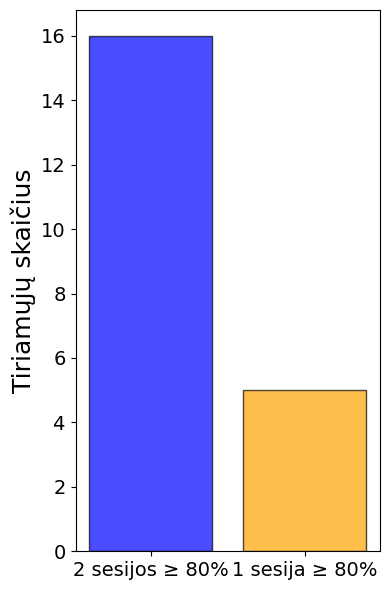

In [232]:
import matplotlib.pyplot as plt

# Filter for subjects with Validation Accuracy >= 80%
top_subjects = top_df_plot[top_df_plot['Validation Accuracy'] >= 0.8]

# Extract Subject_ID and Run
top_subjects['Subject_ID'] = top_subjects['Subject_Run'].str[:2]
top_subjects['Run'] = top_subjects['Subject_Run'].str[-2:]

# Count the number of runs for each subject
run_counts = top_subjects.groupby('Subject_ID')['Run'].nunique()

# Classify subjects
subjects_with_2_runs = run_counts[run_counts == 2].index  # Subjects with both runs
subjects_with_1_run = run_counts[run_counts == 1].index  # Subjects with only 1 run

# Count the number of subjects in each category
counts = {
    '2 sesijos ≥ 80%': len(subjects_with_2_runs),
    '1 sesija ≥ 80%': len(subjects_with_1_run)
}

# Plot the bar chart
plt.figure(figsize=(4, 6))
plt.bar(counts.keys(), counts.values(), color=['blue', 'orange'], edgecolor='black', alpha=0.7)
# plt.title('Number of Subjects with 1 Run vs. 2 Runs ≥ 80% Accuracy')
# plt.ylabel('Number of Subjects')

# plt.title('Tiriamųjų, kurių viena ir dvi sesijos pasiekia >80%')
plt.ylabel('Tiriamųjų skaičius')
set_plot_styles(plt.gca(), title_size=18, label_size=18, tick_size=14, legend_size=16)

plt.tight_layout()
plt.show()


C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3538011272.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plot = top_df_plot[top_df_plot['Subject_Run'].isin(top_subjects['Subject_Run'])][top_df_plot['Model'].isin(top_pipelines)]


Text(0, 0.5, 'Validation Accuracy')

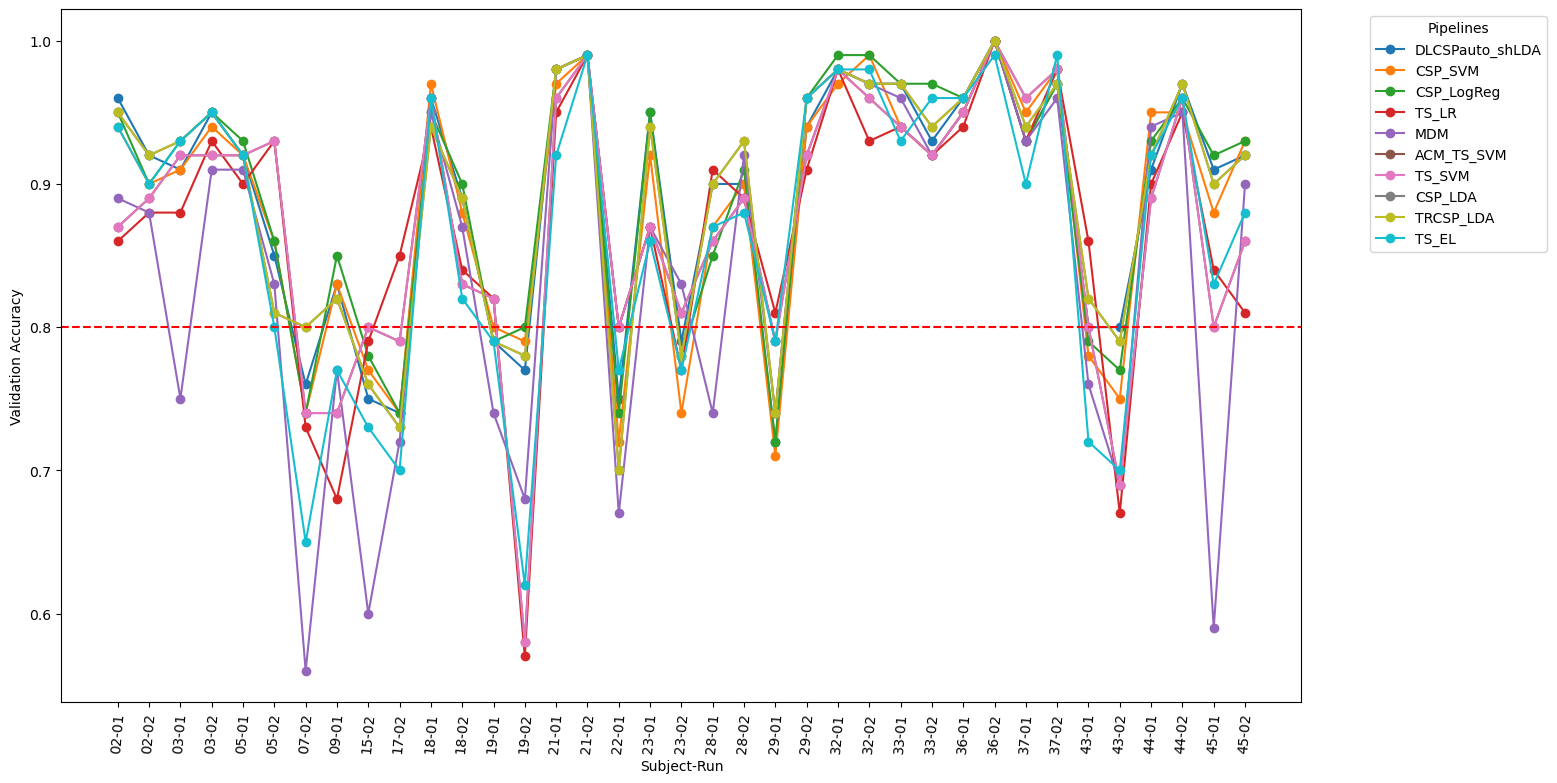

In [246]:
df_plot = top_df_plot[top_df_plot['Subject_Run'].isin(top_subjects['Subject_Run'])][top_df_plot['Model'].isin(top_pipelines)]

pipelines = df_plot['Model'].unique()

plt.figure(figsize=(16, 9))
for pipeline in pipelines:
    subset = df_plot[df_plot['Model'] == pipeline]
    # Sort by Subject_Run for consistent line connection
    subset = subset.sort_values(by='Subject_Run')
    plt.plot(
        subset['Subject_Run'], 
        subset['Validation Accuracy'], 
        marker='o', 
        label=pipeline
    )
plt.xticks(rotation=85);  # Rotate x-axis labels for better readability
plt.legend(title="Pipelines", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axhline(y=0.8, color='red', linestyle='--', linewidth=1.5, label='Threshold: 0.8')
plt.xlabel("Subject-Run")
plt.ylabel("Validation Accuracy")

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\3418731055.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_stacked = df.stack(level=[0,1]).reset_index().drop(columns=['level_1','level_0']).groupby('level_2').mean()


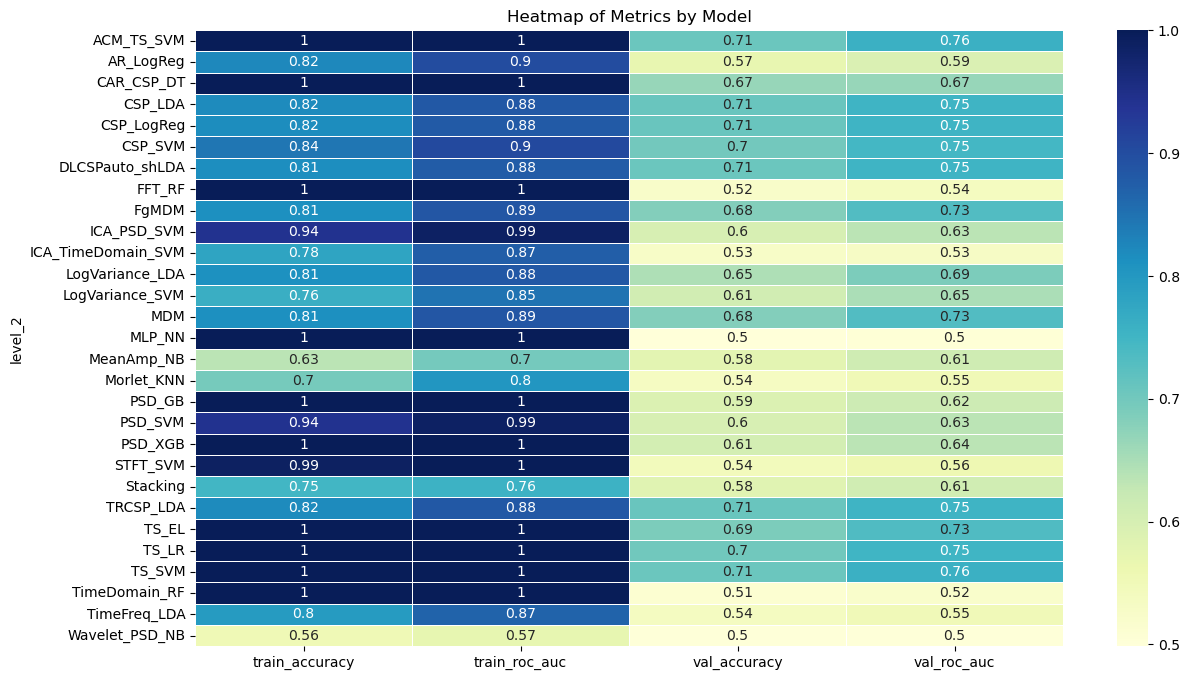

In [13]:
# Su visais

df_stacked = df.stack(level=[0,1]).reset_index().drop(columns=['level_1','level_0']).groupby('level_2').mean()

plt.figure(figsize=(14, 8))
sns.heatmap(df_stacked, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Metrics by Model')
plt.show()

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\687015055.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_filtered_stacked = filtered_df.stack(level=[0,1]).reset_index().drop(columns=['level_1','level_0']).groupby('level_2').mean()


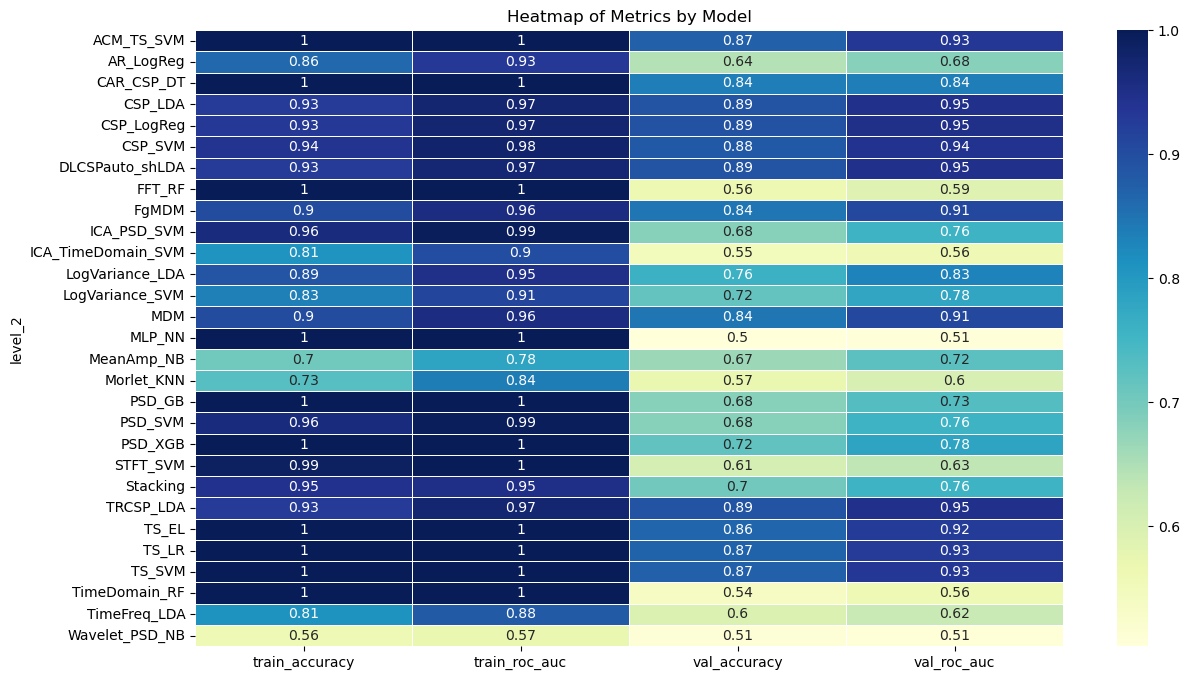

In [14]:
# Su geraisiais 
filtered_df = df.loc[:, df.columns.get_level_values(0).isin(top_subjects.Subject_Run)]
df_filtered_stacked = filtered_df.stack(level=[0,1]).reset_index().drop(columns=['level_1','level_0']).groupby('level_2').mean()

plt.figure(figsize=(14, 8))
sns.heatmap(df_filtered_stacked, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Metrics by Model')
plt.show()

In [15]:
df_1 = df_stacked[3:4][['train_accuracy','val_accuracy']]
df_2 = df_filtered_stacked[3:4][['train_accuracy','val_accuracy']]

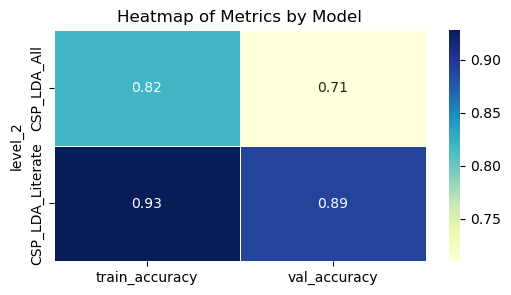

In [16]:
df_1 = df_1.rename(index={df_2.index[0]: 'CSP_LDA_All'})
df_2 = df_2.rename(index={df_2.index[0]: 'CSP_LDA_Literate'})

# Combine DataFrames
df_combined = pd.concat([df_1, df_2])

# Plotting the heatmap
plt.figure(figsize=(6, 3))
sns.heatmap(df_combined, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Metrics by Model')
plt.show()

In [17]:
df_stacked = df.stack(level=[0,1]).reset_index().drop(columns=['level_1','level_0']).groupby('level_2').agg(['mean', 'std']).loc[:, (slice(None), ['mean', 'std'])] * 100
df_stacked

C:\Users\rokas\AppData\Local\Temp\ipykernel_25432\395764350.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_stacked = df.stack(level=[0,1]).reset_index().drop(columns=['level_1','level_0']).groupby('level_2').agg(['mean', 'std']).loc[:, (slice(None), ['mean', 'std'])] * 100


train_accuracy            train_roc_auc                \
                             mean        std          mean           std   
level_2                                                                    
ACM_TS_SVM              99.971154   0.243677     99.999760  5.481613e-03   
AR_LogReg               82.264423   6.402412     90.075481  4.721470e+00   
CAR_CSP_DT             100.000000   0.000000    100.000000  0.000000e+00   
CSP_LDA                 81.810096  11.475947     88.258774  1.026795e+01   
CSP_LogReg              81.713942  11.679652     87.938702  1.042118e+01   
CSP_SVM                 84.495192  10.401848     90.476322  8.963258e+00   
DLCSPauto_shLDA         81.435096  11.877769     87.761058  1.085613e+01   
FFT_RF                 100.000000   0.000000    100.000000  2.532261e-15   
FgMDM                   81.293269  11.733146     88.510937  9.460732e+00   
ICA_PSD_SVM             94.137019   5.729311     98.779207  2.447420e+00   
ICA_TimeDomain_SVM      77.937500   5.792842     87.342067  4.970737e+00   
LogVariance_LDA         81.084135   8.487113     88.322837  6.961342e+00   
LogVariance_SVM         76.127404   8.431264     84.810216  7.145025e+00   
MDM                     81.293269  11.733146     88.510937  9.460732e+00   
MLP_NN                  99.997596   0.054816    100.000000  0.000000e+00   
MeanAmp_NB              63.456731   9.709685     69.752704  1.021724e+01   
Morlet_KNN              69.562500   7.273453     80.275541  5.939944e+00   
PSD_GB                 100.000000   0.000000    100.000000  4.873338e-16   
PSD_SVM                 94.137019   5.729311     98.779207  2.447420e+00   
PSD_XGB                100.000000   0.000000    100.000000  0.000000e+00   
STFT_SVM                98.829327   1.797244     99.957332  2.698447e-01   
Stacking                74.930288  35.907725     75.635577  3.809301e+01   
TRCSP_LDA               81.810096  11.475947     88.258774  1.026795e+01   
TS_EL                  100.000000   0.000000    100.000000  3.004127e-15   
TS_LR                  100.000000   0.000000    100.000000  0.000000e+00   
TS_SVM                  99.971154   0.243677     99.999760  5.481613e-03   
TimeDomain_RF          100.000000   0.000000    100.000000  4.873338e-16   
TimeFreq_LDA            79.581731   4.491139     86.825361  3.558621e+00   
Wavelet_PSD_NB          55.504808   4.410448     57.281731  5.421469e+00   

                   val_accuracy            val_roc_auc             
                           mean        std        mean        std  
level_2                                                            
ACM_TS_SVM            70.769231  17.186067   76.100000  18.415814  
AR_LogReg             57.105769  13.802152   59.451923  16.189913  
CAR_CSP_DT            66.684783  18.015322   66.684783  18.015322  
CSP_LDA               70.990385  18.316157   75.263462  19.772546  
CSP_LogReg            71.009615  18.495688   75.280769  19.969293  
CSP_SVM               69.951923  18.298204   74.680769  19.883234  
DLCSPauto_shLDA       70.750000  18.336792   75.263462  19.806040  
FFT_RF                52.451923  12.577222   53.798077  14.635408  
FgMDM                 68.288462  18.350932   73.267308  19.582927  
ICA_PSD_SVM           59.663462  13.469877   63.394231  16.784144  
ICA_TimeDomain_SVM    52.663462  11.441070   53.157692  14.327108  
LogVariance_LDA       64.605769  15.419265   68.938462  17.705035  
LogVariance_SVM       60.750000  14.898985   64.757692  17.810795  
MDM                   68.288462  18.350932   73.267308  19.582927  
MLP_NN                49.865385  11.228969   50.339423  12.997802  
MeanAmp_NB            57.721154  14.319810   61.071154  17.224594  
Morlet_KNN            53.528846  11.851649   55.190385  14.662888  
PSD_GB                59.221154  14.853788   61.600000  17.176030  
PSD_SVM               59.663462  13.469877   63.394231  16.784144  
PSD_XGB               60.528846  15.752149   63.557692  18.647437  
STFT_SVM              

In [18]:
# models_to_keep = ['CSP_LogReg','TRCSP_LDA','CSP_LDA','DLCSPauto_shLDA','ACM_TS_SVM','TS_SVM','TS_LR','CSP_SVM',
#                   'TS_EL', 'MDM', 'FgMDM', 'CAR_CSP_DT', 'LogVariance_LDA', 'PSD_XGB', 'LogVariance_SVM']
#15 pagal scores geriausiu

#Apačioj pagal moabba

models_to_keep = ['ACM_TS_SVM', 'TS_LR', 'FgMDM', 'TS_SVM', 'TS_EL', 'FilterBank_SVM', 'CSP_SVM', 
        'DLCSPaut0_shLDA', 'CSP_LDA', 'MDM', 'TRCSP_LDA', 'LogVariance_LDA', 'LogVariance_SVM']
filtered_df = df_stacked.loc[df_stacked.index.get_level_values('level_2').isin(models_to_keep)]
filtered_df

train_accuracy            train_roc_auc                \
                          mean        std          mean           std   
level_2                                                                 
ACM_TS_SVM           99.971154   0.243677     99.999760  5.481613e-03   
CSP_LDA              81.810096  11.475947     88.258774  1.026795e+01   
CSP_SVM              84.495192  10.401848     90.476322  8.963258e+00   
FgMDM                81.293269  11.733146     88.510937  9.460732e+00   
LogVariance_LDA      81.084135   8.487113     88.322837  6.961342e+00   
LogVariance_SVM      76.127404   8.431264     84.810216  7.145025e+00   
MDM                  81.293269  11.733146     88.510937  9.460732e+00   
TRCSP_LDA            81.810096  11.475947     88.258774  1.026795e+01   
TS_EL               100.000000   0.000000    100.000000  3.004127e-15   
TS_LR               100.000000   0.000000    100.000000  0.000000e+00   
TS_SVM               99.971154   0.243677     99.999760  5.481613e-03   

                val_accuracy            val_roc_auc             
                        mean        std        mean        std  
level_2                                                         
ACM_TS_SVM         70.769231  17.186067   76.100000  18.415814  
CSP_LDA            70.990385  18.316157   75.263462  19.772546  
CSP_SVM            69.951923  18.298204   74.680769  19.883234  
FgMDM              68.288462  18.350932   73.267308  19.582927  
LogVariance_LDA    64.605769  15.419265   68.938462  17.705035  
LogVariance_SVM    60.750000  14.898985   64.757692  17.810795  
MDM                68.288462  18.350932   73.267308  19.582927  
TRCSP_LDA          70.990385  18.316157   75.263462  19.772546  
TS_EL              68.884615  18.289214   73.378846  19.799275  
TS_LR              70.096154  17.381317   74.994231  18.620279  
TS_SVM             70.769231  17.186067   76.100000  18.415814

## moabb paskelbti rezultatai ir paskaičiuoti

In [19]:
import pandas as pd

# Data preparation
data = {
    'Model': [
        'ACM_TS_SVM', 'TS_LR', 'FgMDM', 'TS_SVM', 'TS_EL', 'FilterBank_SVM', 'CSP_SVM', 
        'DLCSPaut0_shLDA', 'CSP_LDA', 'MDM', 'TRCSP_LDA', 'LogVariance_LDA', 'LogVariance_SVM'
    ],
    'mean': [83.05, 83.09, 81.34, 83.57, 84.74, 75.07, 77.27, 76.69, 76.88, 70.23, 76.26, 66.21, 73.83],
    'std': [13.97, 13.46, 13.93, 14.08, 13.19, 16.97, 16.73, 17.23, 17.41, 13.87, 15.41, 12.06, 13.85]
}

# Create DataFrame
df_moabb = pd.DataFrame(data)
df_compare = pd.merge(
    df_moabb, 
    df_stacked['val_accuracy'].reset_index().rename(columns={'level_2': 'Model'}), 
    on='Model'
)
df_compare

Model  mean_x  std_x     mean_y      std_y
0        ACM_TS_SVM   83.05  13.97  70.769231  17.186067
1             TS_LR   83.09  13.46  70.096154  17.381317
2             FgMDM   81.34  13.93  68.288462  18.350932
3            TS_SVM   83.57  14.08  70.769231  17.186067
4             TS_EL   84.74  13.19  68.884615  18.289214
5           CSP_SVM   77.27  16.73  69.951923  18.298204
6           CSP_LDA   76.88  17.41  70.990385  18.316157
7               MDM   70.23  13.87  68.288462  18.350932
8         TRCSP_LDA   76.26  15.41  70.990385  18.316157
9   LogVariance_LDA   66.21  12.06  64.605769  15.419265
10  LogVariance_SVM   73.83  13.85  60.750000  14.898985

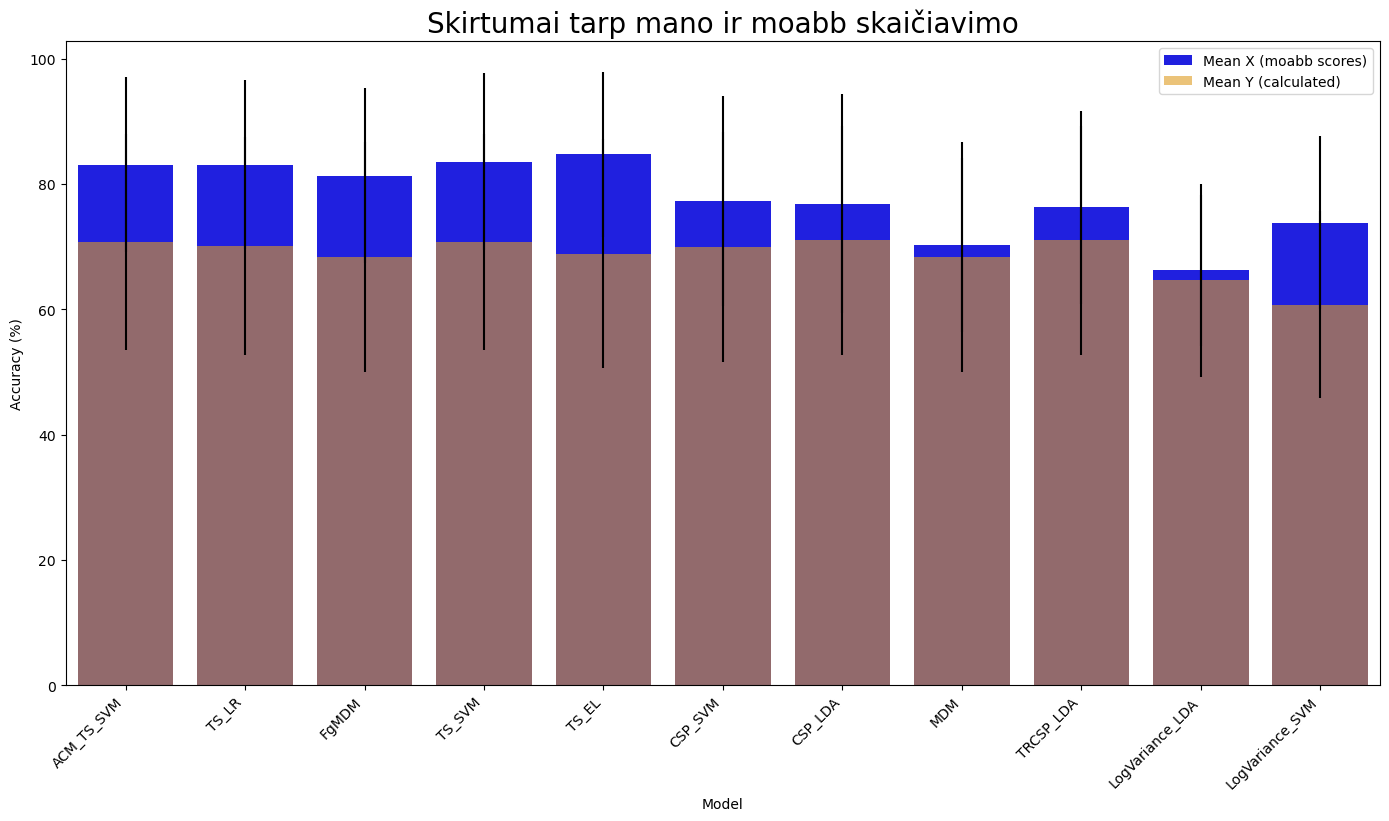

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Set up the figure
plt.figure(figsize=(14, 8))
# Plot mean_x with error bars
sns.barplot(x='Model', y='mean_x', data=df_compare, yerr=df_compare['std_x'], label='Mean X (moabb scores)', color='b', capsize=0.2)

# Overlay mean_y with error bars
sns.barplot(x='Model', y='mean_y', data=df_compare, yerr=df_compare['std_y'], label='Mean Y (calculated)', color='orange', alpha=0.6, capsize=0.2)

# Rotate x labels for better readability
plt.xticks(rotation=45, ha='right')

# Add a legend
plt.legend()

# Set labels and title
plt.ylabel('Accuracy (%)')
# Show plot
plt.tight_layout()
plt.title('Skirtumai tarp mano ir moabb skaičiavimo', fontsize=20)
plt.show()


### Galimai skirtumai tik finetuninimo klausimas

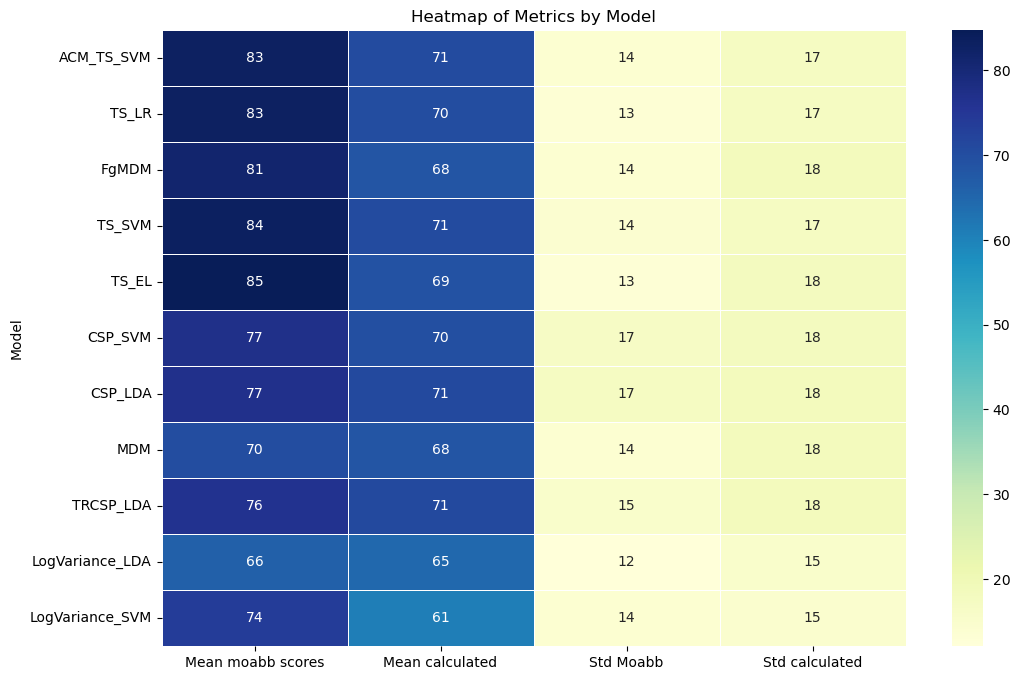

In [21]:
df_compare = df_compare.set_index('Model')

df_compare = df_compare.rename(columns={
    'mean_x': 'Mean moabb scores',
    'mean_y': 'Mean calculated',
    'std_x': 'Std Moabb',
    'std_y': 'Std calculated'
})[['Mean moabb scores', 'Mean calculated', 'Std Moabb', 'Std calculated']]

plt.figure(figsize=(12, 8))
sns.heatmap(df_compare, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Metrics by Model')
plt.show()

# Fine-tuning 

Kolkas nepersistengiau

In [22]:
evaluations = {}
paths = glob.glob(f'C:\\Users\\rokas\\Documents\\GitHub\\BCI\\mi-bci\\data\\results\\fine_tune_scores\\lee2019\\2025-01-04\\*.pkl')

for path in paths:
    filename = os.path.basename(path)
    subject_run = filename.split('_')[-3]
    pipeline_name = filename.split('result')[0][:-1]
    
    if subject_run not in evaluations:
        evaluations[subject_run] = {}
    evaluations[subject_run][pipeline_name] = pd.read_pickle(path)[pipeline_name]


In [23]:
evaluations.keys()

dict_keys(['01-01', '01-02', '02-01', '02-02', '03-01', '03-02', '04-01', '04-02', '05-01', '05-02', '06-01', '06-02', '07-01', '07-02', '08-01', '08-02', '09-01', '09-02', '10-01', '10-02', '11-01', '11-02', '12-01', '12-02', '13-01', '13-02', '14-01', '14-02', '15-01', '15-02', '16-01', '16-02', '17-01', '17-02', '18-01', '18-02', '19-01', '19-02', '20-01', '20-02', '21-01', '21-02', '22-01', '22-02', '23-01', '23-02', '24-01', '24-02', '25-01', '25-02', '26-01', '26-02', '27-01', '27-02', '28-01', '28-02', '29-01', '29-02', '30-01', '30-02', '31-01', '31-02', '32-01', '32-02', '33-01', '33-02', '34-01', '34-02', '35-01', '35-02', '36-01', '36-02', '37-01', '37-02', '38-01', '38-02', '40-01', '40-02', '41-01', '41-02', '42-01', '42-02', '43-01', '43-02', '44-01', '44-02', '45-01', '45-02', '46-01', '46-02', '47-01', '47-02', '48-01', '48-02', '49-01', '49-02', '50-01', '50-02', '51-01', '51-02', '52-01', '52-02', '53-01', '53-02'])

In [24]:
evaluations['01-01'].keys()

dict_keys(['ACM_TS_SVM', 'CAR_CSP_DT', 'CSP_LDA', 'CSP_LogReg', 'CSP_SVM', 'DLCSPauto_shLDA', 'LogVariance_LDA', 'TRCSP_LDA', 'TS_EL', 'TS_LR', 'TS_SVM'])

In [25]:
#Tusčių rezultatų šalinimas
for subject_run_nr in list(evaluations.keys()):
    for pipeline_key in list(evaluations[subject_run_nr].keys()): 
        if evaluations[subject_run_nr][pipeline_key] is None or list(evaluations[subject_run_nr][pipeline_key].keys()) == ['error']:
            del evaluations[subject_run_nr][pipeline_key]

In [26]:
evaluations['01-01'].keys() #daug nan modeliu scoru

dict_keys(['ACM_TS_SVM', 'LogVariance_LDA', 'TS_EL', 'TS_LR', 'TS_SVM'])

In [27]:
evaluations['01-01']['TS_SVM'].keys()

dict_keys(['train_accuracy', 'train_roc_auc', 'val_accuracy', 'val_roc_auc', 'mean_train_accuracy', 'mean_train_auc', 'mean_val_accuracy', 'mean_val_auc', 'best_model', 'best_params', 'cv_results'])

In [28]:
evaluations['01-01']['TS_SVM']['val_accuracy']

array([0.71, 0.71, 0.52, 0.71, 0.71, 0.52, 0.71, 0.52, 0.58, 0.71, 0.57,
       0.58, 0.71, 0.56, 0.58, 0.71, 0.55, 0.58, 0.71, 0.55, 0.58, 0.73,
       0.71, 0.52, 0.73, 0.71, 0.52, 0.73, 0.52, 0.58, 0.73, 0.57, 0.58,
       0.73, 0.56, 0.58, 0.73, 0.55, 0.58, 0.73, 0.55, 0.58, 0.73, 0.75,
       0.51, 0.73, 0.75, 0.51, 0.73, 0.53, 0.58, 0.73, 0.5 , 0.58, 0.73,
       0.56, 0.58, 0.73, 0.55, 0.58, 0.73, 0.55, 0.58, 0.73, 0.74, 0.58,
       0.73, 0.74, 0.58, 0.73, 0.52, 0.58, 0.73, 0.51, 0.58, 0.73, 0.56,
       0.58, 0.73, 0.55, 0.58, 0.73, 0.55, 0.58, 0.73, 0.74, 0.58, 0.73,
       0.74, 0.58, 0.73, 0.52, 0.58, 0.73, 0.51, 0.58, 0.73, 0.56, 0.58,
       0.73, 0.55, 0.58, 0.73, 0.55, 0.58, 0.73, 0.74, 0.58, 0.73, 0.74,
       0.58, 0.73, 0.52, 0.58, 0.73, 0.51, 0.58, 0.73, 0.56, 0.58, 0.73,
       0.55, 0.58, 0.73, 0.55, 0.58, 0.73, 0.74, 0.58, 0.73, 0.74, 0.58,
       0.73, 0.52, 0.58, 0.73, 0.51, 0.58, 0.73, 0.56, 0.58, 0.73, 0.55,
       0.58, 0.73, 0.55, 0.58, 0.73, 0.74, 0.58, 0.

In [29]:
# Initialize a dictionary to collect values
val_accuracy_dict = {}

# Assuming evaluations is a dictionary structured as described
for subject_key, model_data in evaluations.items():  # Iterate over subjects
    val_accuracy_dict[subject_key] = {}
    for model_key, model_metrics in model_data.items():  # Iterate over models for each subject
        val_accuracy_dict[subject_key][model_key] = {
            'train_accuracy': model_metrics['train_accuracy'],
            'train_roc_auc': model_metrics['train_roc_auc'],
            'val_accuracy': model_metrics['val_accuracy'],
            'val_roc_auc': model_metrics['val_roc_auc']
        }

In [30]:
import pandas as pd

# Transform into DataFrame
rows = []
for subject_run, pipelines in val_accuracy_dict.items():
    # Split subject-run into subject and run
    subject, run = subject_run.split('-')
    for pipeline_name, metrics in pipelines.items():
        # Find the maximum number of entries among the metrics
        max_len = max(
            len(metrics['val_accuracy']),
            len(metrics['train_accuracy']),
            len(metrics['val_roc_auc']),
            len(metrics['train_roc_auc'])
        )
        
        # Iterate over each index and populate the rows
        for i in range(max_len):
            rows.append({
                "subject": subject,
                "run": run,
                "subject-run": subject_run,
                "pipeline": pipeline_name,
                "index": i,
                "val_accuracy": metrics['val_accuracy'][i] if i < len(metrics['val_accuracy']) else None,
                "train_accuracy": metrics['train_accuracy'][i] if i < len(metrics['train_accuracy']) else None,
                "val_roc_auc": metrics['val_roc_auc'][i] if i < len(metrics['val_roc_auc']) else None,
                "train_roc_auc": metrics['train_roc_auc'][i] if i < len(metrics['train_roc_auc']) else None
            })

# Create DataFrame
df = pd.DataFrame(rows)


In [31]:
df

subject run subject-run    pipeline  index  val_accuracy  \
0           01  01       01-01  ACM_TS_SVM      0          0.71   
1           01  01       01-01  ACM_TS_SVM      1          0.71   
2           01  01       01-01  ACM_TS_SVM      2          0.52   
3           01  01       01-01  ACM_TS_SVM      3          0.76   
4           01  01       01-01  ACM_TS_SVM      4          0.71   
...        ...  ..         ...         ...    ...           ...   
124795      53  02       53-02      TS_SVM    163          0.56   
124796      53  02       53-02      TS_SVM    164          0.64   
124797      53  02       53-02      TS_SVM    165          0.64   
124798      53  02       53-02      TS_SVM    166          0.56   
124799      53  02       53-02      TS_SVM    167          0.64   

        train_accuracy  val_roc_auc  train_roc_auc  
0               0.9975        0.814        1.00000  
1               1.0000        0.844        1.00000  
2               0.5650        0.614        0.99025  
3               0.9100        0.844        0.98125  
4               0.9975        0.814        1.00000  
...                ...          ...            ...  
124795          1.0000        0.586        1.00000  
124796          1.0000        0.688        1.00000  
124797          1.0000        0.674        1.00000  
124798          1.0000        0.586        1.00000  
124799          1.0000        0.688        1.00000  

[124800 rows x 9 columns]

In [32]:
df_plot = df.loc[:][['subject-run','pipeline','val_accuracy']]
max_val_accuracy_indices = df_plot.groupby(['subject-run', 'pipeline'])['val_accuracy'].idxmax()
df_plot = df_plot.loc[max_val_accuracy_indices].reset_index(drop=True)
df_plot

subject-run         pipeline  val_accuracy
0         01-01       ACM_TS_SVM          0.76
1         01-01  LogVariance_LDA          0.62
2         01-01            TS_EL          0.82
3         01-01            TS_LR          0.79
4         01-01           TS_SVM          0.75
..          ...              ...           ...
515       53-02       ACM_TS_SVM          0.67
516       53-02  LogVariance_LDA          0.59
517       53-02            TS_EL          0.76
518       53-02            TS_LR          0.72
519       53-02           TS_SVM          0.66

[520 rows x 3 columns]

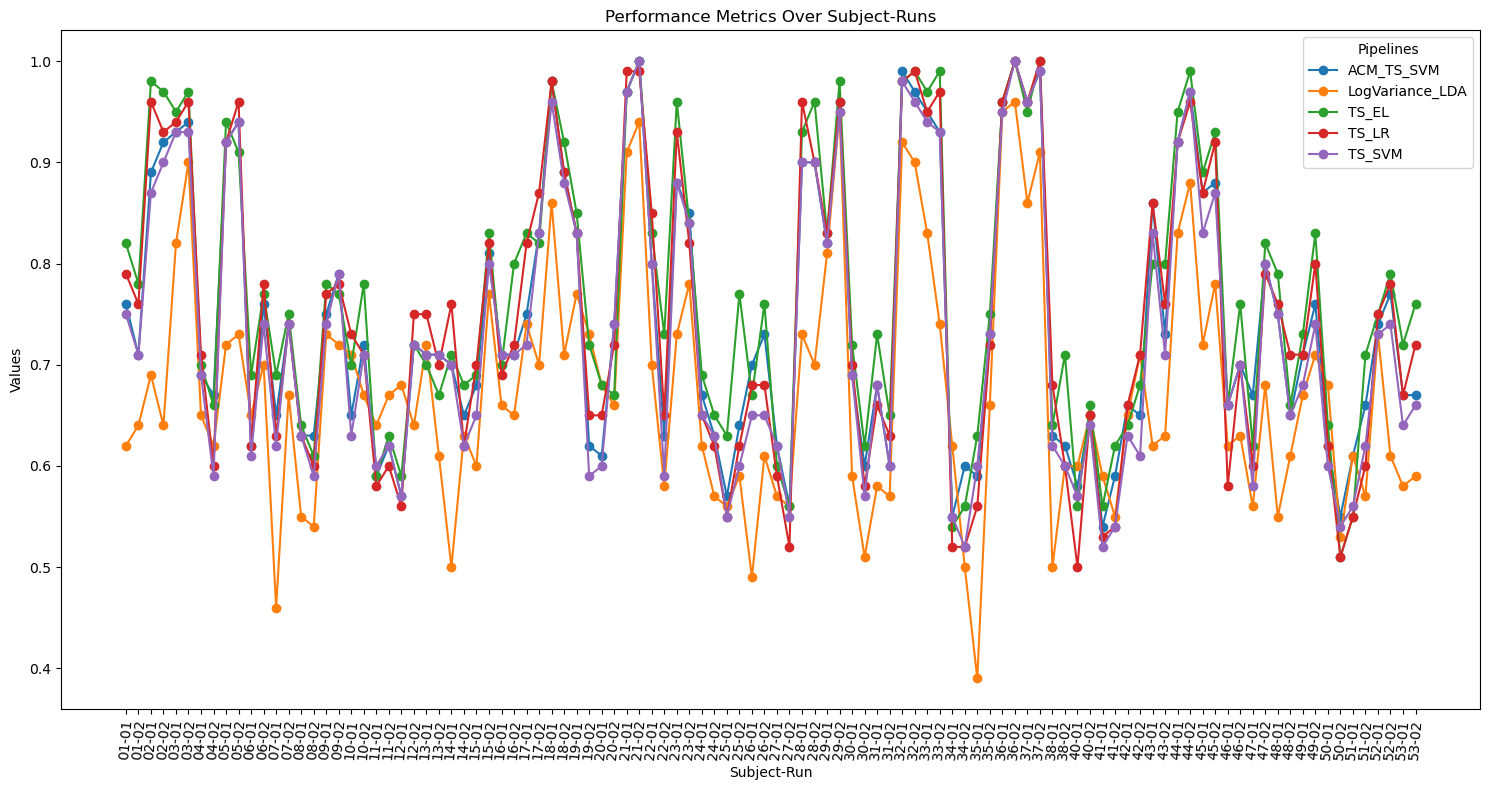

In [33]:
plt.figure(figsize=(15, 8))
for pipeline in df_plot["pipeline"].unique():
    subset = df_plot[df_plot["pipeline"] == pipeline]
    plt.plot(subset["subject-run"], subset['val_accuracy'], marker='o', label=pipeline)

plt.title("Performance Metrics Over Subject-Runs")
plt.xlabel("Subject-Run")
plt.ylabel("Values")
plt.xticks(rotation=85)
plt.legend(title="Pipelines")
plt.tight_layout()
plt.show()

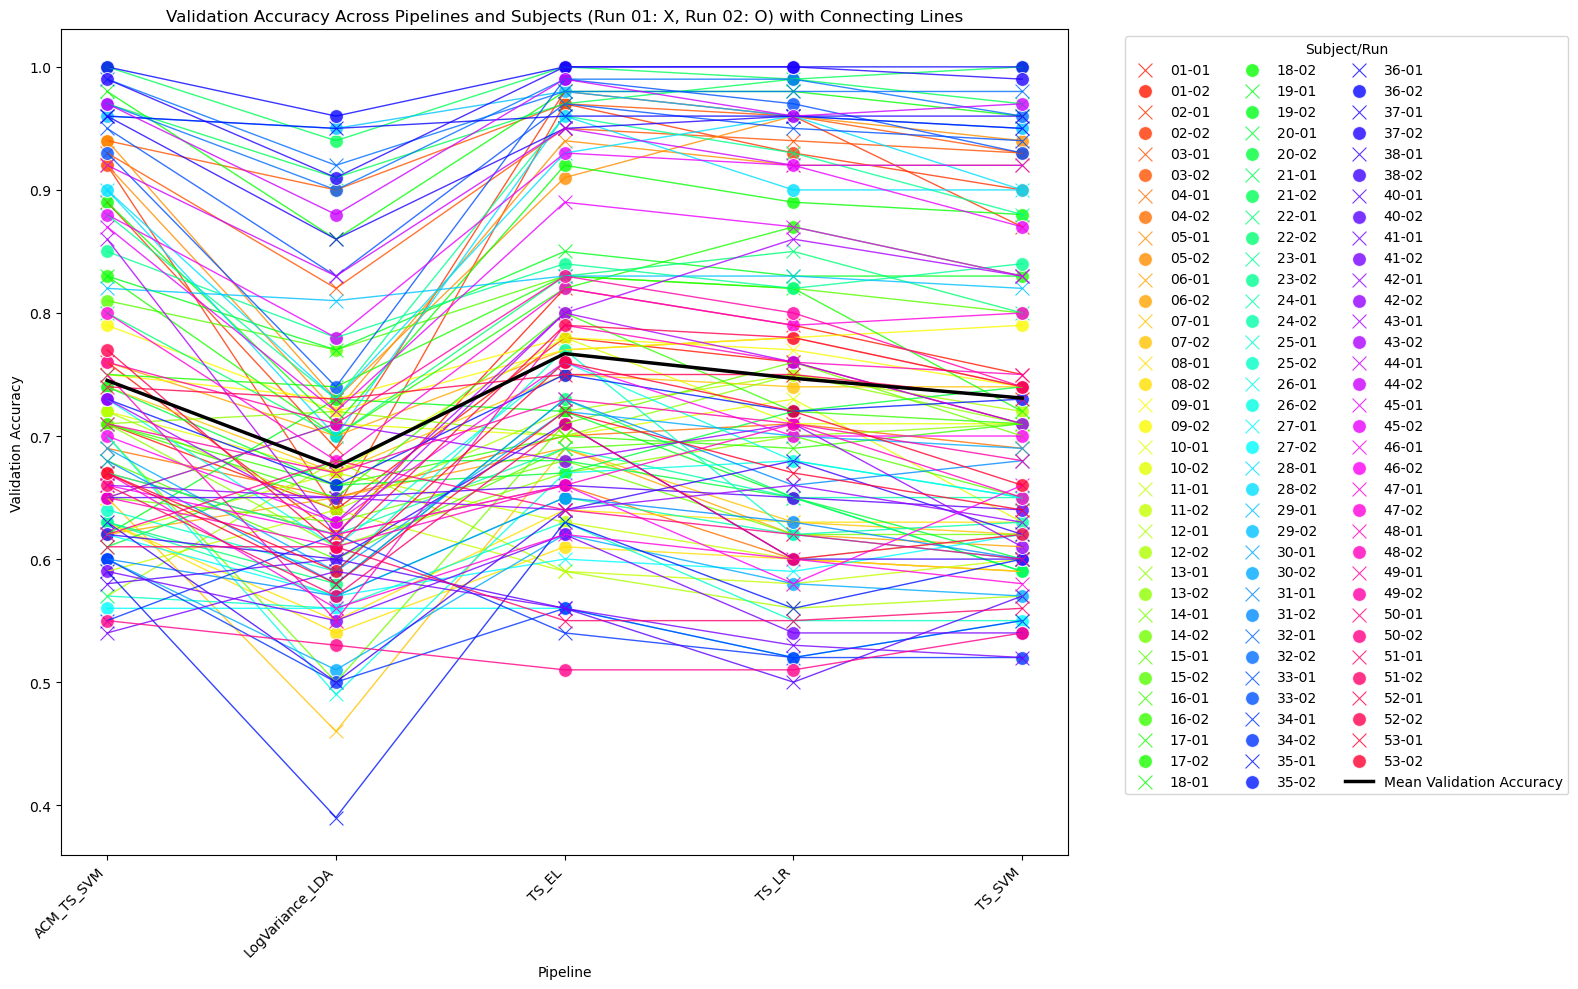

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_plot contains the following columns: 'subject-run', 'pipeline', 'val_accuracy'
# Split 'subject-run' into 'subject' and 'run' columns
df_plot['subject'] = df_plot['subject-run'].str[:2]  # Extract subject IDs
df_plot['run'] = df_plot['subject-run'].str[-2:]     # Extract run numbers

# Assign colors to subjects and shapes to runs
subject_ids = sorted(df_plot['subject'].unique())
subject_color_map = {subject: color for subject, color in zip(subject_ids, sns.color_palette("hsv", len(subject_ids)))}
run_shape_map = {'01': 'x', '02': 'o'}  # Shapes for runs

# Plot
plt.figure(figsize=(16, 10))
for subject in subject_ids:
    # Filter data for the current subject
    subject_data = df_plot[df_plot['subject'] == subject]
    for run, shape in run_shape_map.items():
        # Filter data for the current run
        subset = subject_data[subject_data['run'] == run]
        sns.scatterplot(
            data=subset,
            x='pipeline',
            y='val_accuracy',
            color=subject_color_map[subject],
            marker=shape,
            s=100,
            alpha=0.8,
            label=f"{subject}-{run}"
        )

    # Add lines connecting runs for the same subject across pipelines
    subject_runs = subject_data.pivot(index='pipeline', columns='run', values='val_accuracy')
    if '01' in subject_runs.columns and '02' in subject_runs.columns:
        plt.plot(
            subject_runs.index,
            subject_runs[['01', '02']],
            color=subject_color_map[subject],
            alpha=0.8,
            linewidth=1
        )

# Add a black line for the mean values per pipeline
pipeline_means = df_plot.groupby('pipeline')['val_accuracy'].mean()
plt.plot(
    pipeline_means.index,
    pipeline_means.values,
    color='black',
    linewidth=2.5,
    label='Mean Validation Accuracy'
)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel('Pipeline')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Across Pipelines and Subjects (Run 01: X, Run 02: O) with Connecting Lines')
plt.legend(title='Subject/Run', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=3)
plt.tight_layout()
plt.show()


In [35]:
# Find rows with maximum validation accuracy within each group
max_val_accuracy = df.groupby(['subject', 'run', 'pipeline'])['val_accuracy'].idxmax()

# Select only those rows
filtered_df = df.loc[max_val_accuracy]

# Reset the index for a cleaner DataFrame
filtered_df = filtered_df.reset_index(drop=True)

In [36]:
filtered_df[filtered_df[:]['subject-run']=='01-01']

subject run subject-run         pipeline  index  val_accuracy  \
0      01  01       01-01       ACM_TS_SVM      3          0.76   
1      01  01       01-01  LogVariance_LDA     12          0.62   
2      01  01       01-01            TS_EL     50          0.82   
3      01  01       01-01            TS_LR    149          0.79   
4      01  01       01-01           TS_SVM     43          0.75   

   train_accuracy  val_roc_auc  train_roc_auc  
0          0.9100        0.844       0.981250  
1          0.8325        0.672       0.898375  
2          1.0000        0.870       1.000000  
3          1.0000        0.882       1.000000  
4          1.0000        0.856       1.000000

In [37]:
# Group by 'pipeline' and calculate mean and standard deviation for each metric
summary = filtered_df.groupby('pipeline').agg({
    'train_accuracy': ['mean', 'std'],
    'train_roc_auc': ['mean', 'std'],
    'val_accuracy': ['mean', 'std'],
    'val_roc_auc': ['mean', 'std']
})

# Rename columns to make them more readable
summary.columns = pd.MultiIndex.from_tuples(summary.columns, names=["Metric", "Statistic"])

# Sort index for clarity
summary.sort_index(inplace=True)

In [38]:
summary = summary[summary.select_dtypes(include=['number']).columns] * 100
summary

Metric          train_accuracy            train_roc_auc             \
Statistic                 mean        std          mean        std   
pipeline                                                             
ACM_TS_SVM           86.766827  17.787352     88.847356  17.925920   
LogVariance_LDA      76.781250   9.938811     83.511058  10.030731   
TS_EL                99.985577   0.124766    100.000000   0.000000   
TS_LR                96.189904   6.719727     98.181010   4.486295   
TS_SVM               99.870192   0.348333     99.993029   0.038981   

Metric          val_accuracy            val_roc_auc             
Statistic               mean        std        mean        std  
pipeline                                                        
ACM_TS_SVM         74.519231  13.188684   77.584615  14.525390  
LogVariance_LDA    67.480769  11.792692   71.238462  13.923956  
TS_EL              76.701923  13.525869   78.212500  15.071478  
TS_LR              74.692308  14.523551   77.465385  16.370835  
TS_SVM             73.086538  13.838956   76.365385  15.803538

In [39]:
filtered_df = df_stacked[df_stacked.index.get_level_values('level_2').isin(summary.index.tolist())] #atfiltruoti finetuninti pipelinai is orginalaus nefinetuninto saraso

In [40]:
filtered_df

train_accuracy           train_roc_auc                \
                          mean       std          mean           std   
level_2                                                                
ACM_TS_SVM           99.971154  0.243677     99.999760  5.481613e-03   
LogVariance_LDA      81.084135  8.487113     88.322837  6.961342e+00   
TS_EL               100.000000  0.000000    100.000000  3.004127e-15   
TS_LR               100.000000  0.000000    100.000000  0.000000e+00   
TS_SVM               99.971154  0.243677     99.999760  5.481613e-03   

                val_accuracy            val_roc_auc             
                        mean        std        mean        std  
level_2                                                         
ACM_TS_SVM         70.769231  17.186067   76.100000  18.415814  
LogVariance_LDA    64.605769  15.419265   68.938462  17.705035  
TS_EL              68.884615  18.289214   73.378846  19.799275  
TS_LR              70.096154  17.381317   74.994231  18.620279  
TS_SVM             70.769231  17.186067   76.100000  18.415814

In [41]:
combined_df = pd.concat([summary, filtered_df], axis=1)
combined_df

train_accuracy            train_roc_auc             \
                          mean        std          mean        std   
ACM_TS_SVM           86.766827  17.787352     88.847356  17.925920   
LogVariance_LDA      76.781250   9.938811     83.511058  10.030731   
TS_EL                99.985577   0.124766    100.000000   0.000000   
TS_LR                96.189904   6.719727     98.181010   4.486295   
TS_SVM               99.870192   0.348333     99.993029   0.038981   

                val_accuracy            val_roc_auc            train_accuracy  \
                        mean        std        mean        std           mean   
ACM_TS_SVM         74.519231  13.188684   77.584615  14.525390      99.971154   
LogVariance_LDA    67.480769  11.792692   71.238462  13.923956      81.084135   
TS_EL              76.701923  13.525869   78.212500  15.071478     100.000000   
TS_LR              74.692308  14.523551   77.465385  16.370835     100.000000   
TS_SVM             73.086538  13.838956   76.365385  15.803538      99.971154   

                          train_roc_auc               val_accuracy             \
                      std          mean           std         mean        std   
ACM_TS_SVM       0.243677     99.999760  5.481613e-03    70.769231  17.186067   
LogVariance_LDA  8.487113     88.322837  6.961342e+00    64.605769  15.419265   
TS_EL            0.000000    100.000000  3.004127e-15    68.884615  18.289214   
TS_LR            0.000000    100.000000  0.000000e+00    70.096154  17.381317   
TS_SVM           0.243677     99.999760  5.481613e-03    70.769231  17.186067   

                val_roc_auc             
                       mean        std  
ACM_TS_SVM        76.100000  18.415814  
LogVariance_LDA   68.938462  17.705035  
TS_EL             73.378846  19.799275  
TS_LR             74.994231  18.620279  
TS_SVM            76.100000  18.415814

In [42]:
import pandas as pd

# Add titles directly as a DataFrame with preserved index
summary_with_title = pd.concat([
    pd.DataFrame([["Fine-Tuned"] * len(summary.columns)], columns=summary.columns, index=[""]),
    summary
])

filtered_df_with_title = pd.concat([
    pd.DataFrame([["Non-Tuned"] * len(filtered_df.columns)], columns=filtered_df.columns, index=[""]),
    filtered_df
])

# Combine both DataFrames
combined_df = pd.concat([summary_with_title,filtered_df_with_title],axis=1)

combined_df


train_accuracy             train_roc_auc              \
                          mean         std          mean         std   
                    Fine-Tuned  Fine-Tuned    Fine-Tuned  Fine-Tuned   
ACM_TS_SVM           86.766827   17.787352     88.847356    17.92592   
LogVariance_LDA       76.78125    9.938811     83.511058   10.030731   
TS_EL                99.985577    0.124766         100.0         0.0   
TS_LR                96.189904    6.719727      98.18101    4.486295   
TS_SVM               99.870192    0.348333     99.993029    0.038981   

                val_accuracy             val_roc_auc              \
                        mean         std        mean         std   
                  Fine-Tuned  Fine-Tuned  Fine-Tuned  Fine-Tuned   
ACM_TS_SVM         74.519231   13.188684   77.584615    14.52539   
LogVariance_LDA    67.480769   11.792692   71.238462   13.923956   
TS_EL              76.701923   13.525869     78.2125   15.071478   
TS_LR              74.692308   14.523551   77.465385   16.370835   
TS_SVM             73.086538   13.838956   76.365385   15.803538   

                train_accuracy            train_roc_auc             \
                          mean        std          mean        std   
                     Non-Tuned  Non-Tuned     Non-Tuned  Non-Tuned   
ACM_TS_SVM           99.971154   0.243677      99.99976   0.005482   
LogVariance_LDA      81.084135   8.487113     88.322837   6.961342   
TS_EL                    100.0        0.0         100.0        0.0   
TS_LR                    100.0        0.0         100.0        0.0   
TS_SVM               99.971154   0.243677      99.99976   0.005482   

                val_accuracy            val_roc_auc             
                        mean        std        mean        std  
                   Non-Tuned  Non-Tuned   Non-Tuned  Non-Tuned  
ACM_TS_SVM         70.769231  17.186067        76.1  18.415814  
LogVariance_LDA    64.605769  15.419265   68.938462  17.705035  
TS_EL              68.884615  18.289214   73.378846  19.799275  
TS_LR              70.096154  17.381317   74.994231  18.620279  
TS_SVM             70.769231  17.186067        76.1  18.415814

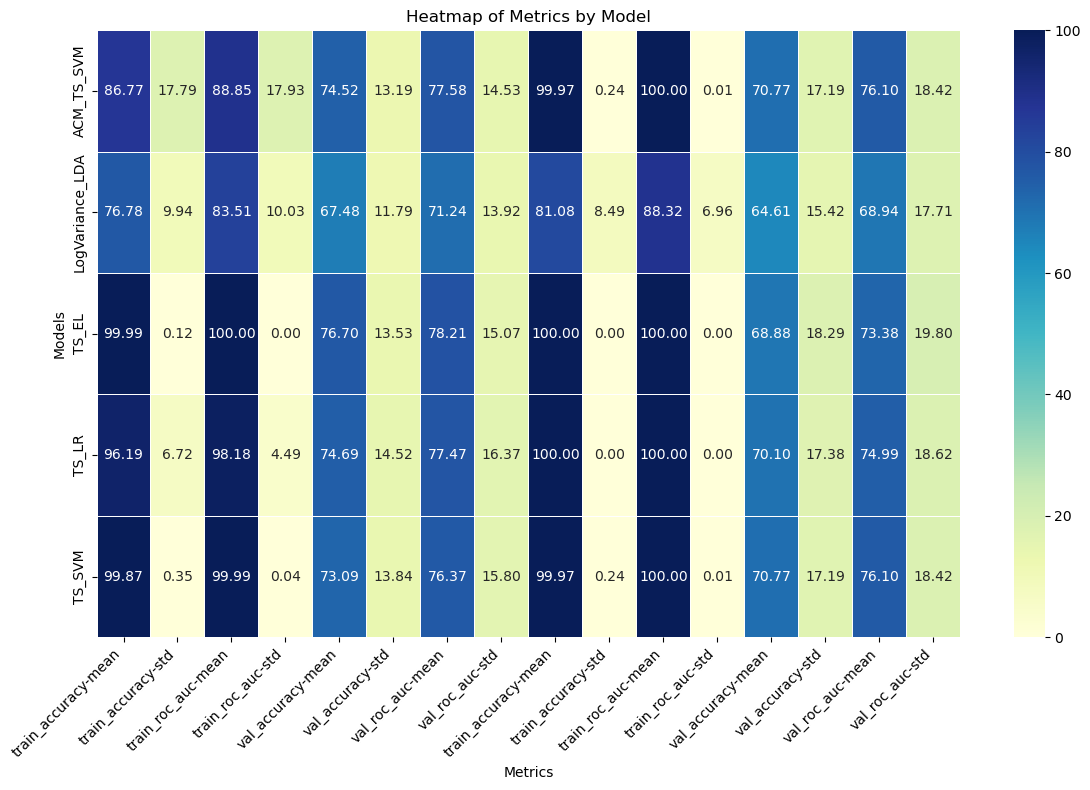

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop non-numerical rows (titles) and ensure numeric values
heatmap_data = combined_df.apply(pd.to_numeric, errors='coerce').dropna()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,  # Annotate cells with values
    cmap="YlGnBu",  # Colormap
    linewidths=0.5,  # Linewidth for better grid separation
    fmt=".2f"  # Format of annotations
)

plt.title('Heatmap of Metrics by Model')
plt.xlabel('Metrics')
plt.ylabel('Models')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [44]:
# Filter out columns where the second level is 'std'
df_without_std = combined_df.loc[:, combined_df.columns.get_level_values(1) != 'std']
df_without_std.columns = df_without_std.columns.droplevel(1) 
df_without_std

train_accuracy train_roc_auc val_accuracy val_roc_auc  \
                    Fine-Tuned    Fine-Tuned   Fine-Tuned  Fine-Tuned   
ACM_TS_SVM           86.766827     88.847356    74.519231   77.584615   
LogVariance_LDA       76.78125     83.511058    67.480769   71.238462   
TS_EL                99.985577         100.0    76.701923     78.2125   
TS_LR                96.189904      98.18101    74.692308   77.465385   
TS_SVM               99.870192     99.993029    73.086538   76.365385   

                train_accuracy train_roc_auc val_accuracy val_roc_auc  
                     Non-Tuned     Non-Tuned    Non-Tuned   Non-Tuned  
ACM_TS_SVM           99.971154      99.99976    70.769231        76.1  
LogVariance_LDA      81.084135     88.322837    64.605769   68.938462  
TS_EL                    100.0         100.0    68.884615   73.378846  
TS_LR                    100.0         100.0    70.096154   74.994231  
TS_SVM               99.971154      99.99976    70.769231        76.1

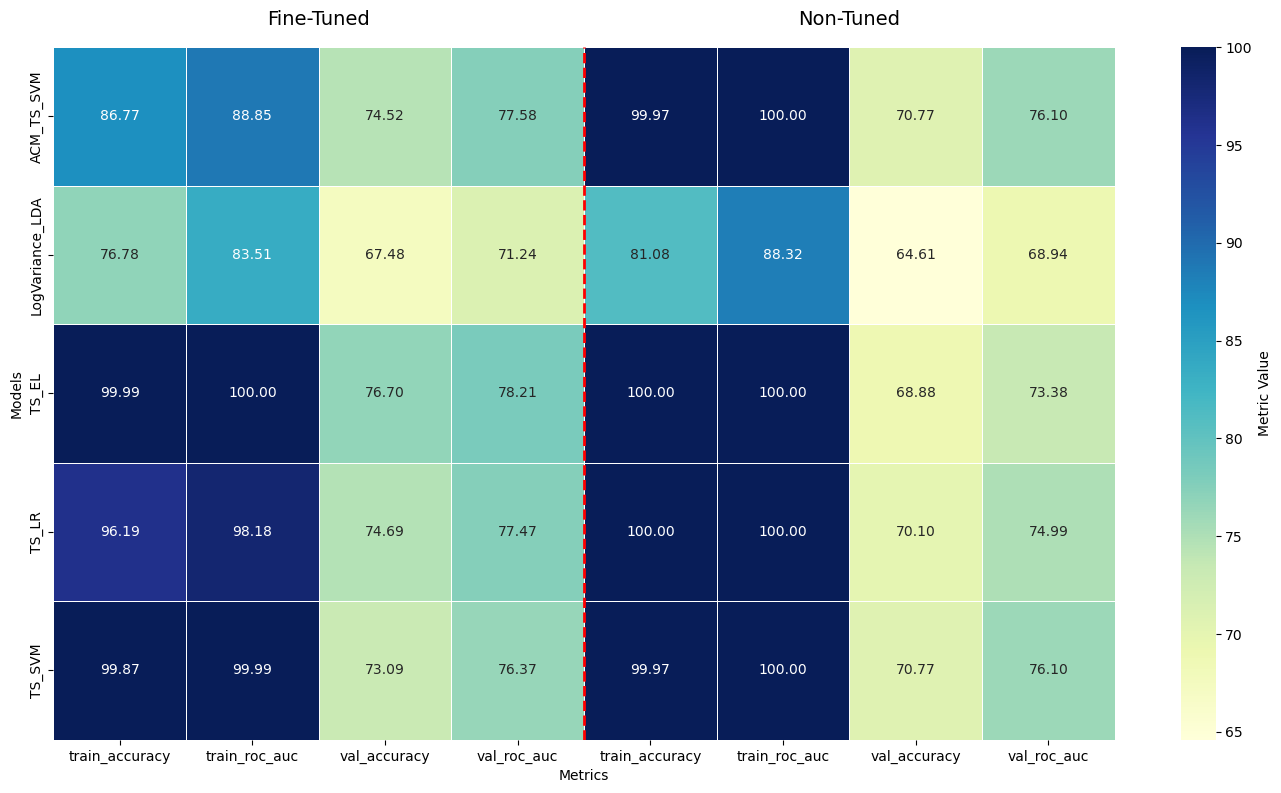

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop the first row with "Fine-Tuned" and "Non-Tuned" labels
heatmap_data = df_without_std.iloc[1:].copy()  # Exclude the first row

# Ensure the data is numeric
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')

# Define the number of Fine-Tuned and Non-Tuned columns
fine_tuned_count = 4  # First 4 columns are Fine-Tuned
non_tuned_count = heatmap_data.shape[1] - fine_tuned_count  # Remaining columns are Non-Tuned

# Plot heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(
    heatmap_data,
    annot=True,
    cmap="YlGnBu",
    linewidths=0.5,
    fmt=".2f",
    cbar_kws={'label': 'Metric Value'}
)

# Add separators or annotations
plt.xlabel("Metrics")
plt.ylabel("Models")

# Add a vertical line to separate Fine-Tuned and Non-Tuned
ax.axvline(x=fine_tuned_count, color='red', linestyle='--', linewidth=2, label='Separator')
plt.text(
    fine_tuned_count / 2, 
    -0.2, 
    "Fine-Tuned", 
    ha='center', 
    va='center', 
    fontsize=14, 
    color='black'
)
plt.text(
    fine_tuned_count + non_tuned_count / 2, 
    -0.2, 
    "Non-Tuned", 
    ha='center', 
    va='center', 
    fontsize=14,  
    color='Black'
)
plt.xticks(rotation=0, ha='center')

plt.tight_layout()
plt.show()


![image.png](attachment:image.png)

In [46]:
#straipsnis 

data = """
Se1,Se2
61.0,83.0
96.0,86.0
95.0,94.0
53.0,57.0
94.0,81.0
77.0,88.0
49.0,71.0
57.0,66.0
86.0,71.0
65.0,61.0
47.0,50.0
46.0,58.0
56.0,54.0
58.0,48.0
55.0,57.0
53.0,69.0
83.0,42.0
92.0,82.0
82.0,89.0
59.0,73.0
98.0,100.0
77.0,85.0
54.0,68.0
49.0,54.0
54.0,57.0
49.0,44.0
56.0,70.0
94.0,97.0
99.0,98.0
76.0,66.0
58.0,57.0
56.0,97.0
99.0,89.0
48.0,47.0
52.0,52.0
97.0,94.0
93.0,81.0
56.0,52.0
64.0,52.0
46.0,58.0
62.0,48.0
47.0,63.0
77.0,86.0
99.0,100.0
93.0,99.0
53.0,58.0
44.0,59.0
50.0,49.0
63.0,62.0
59.0,58.0
71.0,52.0
72.0,72.0
50.0,54.0
53.0,45.0
67.3,68.6
18.3,17.6
"""

# Converting this into a pandas DataFrame
import pandas as pd
from io import StringIO

df_article = pd.read_csv(StringIO(data)) #39 subject nėra calculated data,
df_article = df_article.drop(index=38).reset_index()[['Se1','Se2']]

In [47]:
filtered_columns = df_original.loc[:, df_original.columns.get_level_values(1).isin(['CSP_LDA'])]
filtered_columns = filtered_columns.loc[:, filtered_columns.columns.get_level_values(2) == 'val_accuracy']
top_index = filtered_columns.columns.get_level_values(0)

calculated_df = pd.DataFrame({
    'Subject': top_index,
    'Validation Accuracy': [filtered_columns[x].mean() for x in top_index]
})

calculated_df['Validation Accuracy'] = calculated_df['Validation Accuracy'].apply(
    lambda x: x.values[0] if hasattr(x, 'values') else x
)
calculated_df[['Subject Number', 'Run']] = calculated_df['Subject'].str.split('-', expand=True)

# Pivot the table to make 'Subject Number' the index and 'Run' the columns
transformed_df = calculated_df.pivot(index='Subject Number', columns='Run', values='Validation Accuracy')

# Rename the columns to Se1 and Se2
transformed_df = transformed_df.rename(columns={'01': 'Se1', '02': 'Se2'})
transformed_df *= 100
transformed_df = transformed_df.reset_index()[:][['Se1','Se2']]

df_epochs = pd.DataFrame()

df_epochs['Se1(article)'] = df_article['Se1']
df_epochs['Se2(article)'] = df_article['Se2']

df_epochs['Se1(calculated)'] = transformed_df['Se1']
df_epochs['Se2(calculated)'] = transformed_df['Se2']
df_epochs['Se1_diff'] = df_epochs['Se1(article)'] - df_epochs['Se1(calculated)']
df_epochs['Se2_diff'] = df_epochs['Se2(article)'] - df_epochs['Se2(calculated)']

df_epochs = df_epochs.dropna()
column_means = df_epochs.mean()
df_epochs.loc['Mean'] = column_means

selected_columns = ['Se1(article)', 'Se1(calculated)', 'Se2(article)', 'Se2(calculated)']


In [48]:
df_epochs[selected_columns]

Se1(article)  Se1(calculated)  Se2(article)  Se2(calculated)
0        61.000000        55.000000     83.000000        75.000000
1        96.000000        95.000000     86.000000        92.000000
2        95.000000        93.000000     94.000000        95.000000
3        53.000000        53.000000     57.000000        54.000000
4        94.000000        92.000000     81.000000        81.000000
5        77.000000        58.000000     88.000000        79.000000
6        49.000000        68.000000     71.000000        80.000000
7        57.000000        61.000000     66.000000        53.000000
8        86.000000        82.000000     71.000000        74.000000
9        65.000000        66.000000     61.000000        72.000000
10       47.000000        54.000000     50.000000        59.000000
11       46.000000        60.000000     58.000000        63.000000
12       56.000000        63.000000     54.000000        57.000000
13       58.000000        72.000000     48.000000        53.000000
14       55.000000        60.000000     57.000000        76.000000
15       53.000000        63.000000     69.000000        54.000000
16       83.000000        76.000000     42.000000        73.000000
17       92.000000        94.000000     82.000000        89.000000
18       82.000000        79.000000     89.000000        78.000000
19       59.000000        66.000000     73.000000        70.000000
20       98.000000        98.000000    100.000000        99.000000
21       77.000000        70.000000     85.000000        75.000000
22       54.000000        94.000000     68.000000        78.000000
23       49.000000        61.000000     54.000000        57.000000
24       54.000000        51.000000     57.000000        53.000000
25       49.000000        61.000000     44.000000        49.000000
26       56.000000        53.000000     70.000000        46.000000
27       94.000000        90.000000     97.000000        93.000000
28       99.000000        74.000000     98.000000        96.000000
29       76.000000        69.000000     66.000000        59.000000
30       58.000000        60.000000     57.000000        54.000000
31       56.000000        98.000000     97.000000        97.000000
32       99.000000        97.000000     89.000000        94.000000
33       48.000000        54.000000     47.000000        52.000000
34       52.000000        53.000000     52.000000        58.000000
35       97.000000        96.000000     94.000000       100.000000
36       93.000000        94.000000     81.000000        97.000000
37       56.000000        47.000000     52.000000        62.000000
38       46.000000        56.000000     58.000000        55.000000
39       62.000000        53.000000     48.000000        50.000000
40       47.000000        63.000000     63.000000        60.000000
41       77.000000        82.000000     86.000000        79.000000
42       99.000000        92.000000    100.000000        97.000000
43       93.000000        90.000000     99.000000        92.000000
44       53.000000        54.000000     58.000000        73.000000
45       44.000000        50.000000     59.000000        78.000000
46       50.000000        70.000000     49.000000        61.000000
47       63.000000        78.000000     62.000000        76.000000
48       59.000000        60.000000     58.000000        46.000000
49       71.000000        55.000000     52.000000        60.000000
50       72.000000        74.000000     72.000000        74.000000
51       50.000000        66.000000     54.000000        63.000000
Mean     67.596154        70.634615     69.346154        71.346154

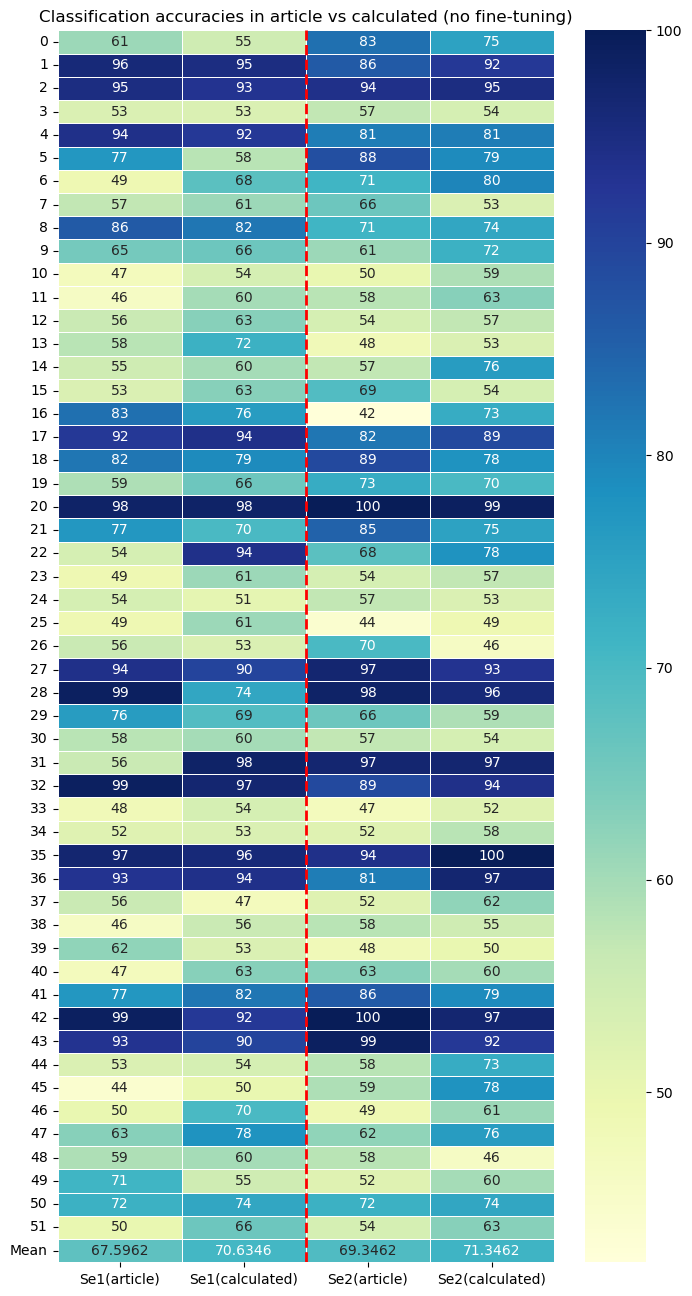

In [49]:
# Plot the heatmap
plt.figure(figsize=(8, 16))
sns.heatmap(
    df_epochs[selected_columns],  # Select specific columns
    annot=True,
    cmap="YlGnBu",
    linewidths=0.5,
    fmt="g"
)

# Add title
plt.title('Classification accuracies in article vs calculated (no fine-tuning)')
middle_position = len(selected_columns) / 2  # Middle of the 4 columns
plt.axvline(middle_position, color='red', linestyle='--', linewidth=2)

plt.yticks(rotation=0, ha='right')
plt.show()
